In [65]:
import os
import re
import sys
import glob
import time
import uproot
import peakutils

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from matplotlib.colors import LogNorm

from scipy.signal import savgol_filter

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('/Users/romoluque_c/Repositories/BACON_romo/') ## Choose right path
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 14

In [4]:
import matplotlib

# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [5]:
fav_col = '#418094'

In [6]:
## filename = '/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-11_25_2024-file_78.root'
## infile   = uproot.open(filename)
## RawTree  = infile['RawTree']

## Analyze files

In [7]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/'

thr_ADC        = 80
sg_filt_window = 30
min_dist       = 50

def extract_date_obj_and_number(filename):
    match       = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    date_str    = match.group(1)
    file_number = int(match.group(2))
    date_obj    = datetime.strptime(date_str, "%m_%d_%Y")
    return date_obj, file_number

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

def adapt_evt_id(evt_id, fnum):
    return 1000000*fnum + np.array(evt_id)

filt_files   = glob.glob(evts_path + f'/BACoN_run3_hits_and_times_thr{thr_ADC}_mean_w{sg_filt_window}_dist{min_dist}_abs_vals_run-*')
sorted_files = sorted(filt_files, key=extract_date_obj_and_number)

In [8]:
start_time = time.time()

filt_evts_dict  = {}
idx_max         = {}
height_sg       = {}
idx_max_trigg   = {}
height_sg_trigg = {}

normal_chs  = range(9)
trigger_chs = [9, 10, 11]

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)

    if date not in filt_evts_dict:
        print(date)
        filt_evts_dict[date] = {ch: d['filt_evts_dict']                .item()[ch]  for ch in normal_chs}
        idx_max       [date] = {ch: np.concatenate(d['idx_peaks_max']  .item()[ch]) for ch in normal_chs}
        height_sg     [date] = {ch: np.concatenate(d['height_peaks_sg'].item()[ch]) for ch in normal_chs}
    else:
        for ch in normal_chs:
            try:
                filt_evts_dict[date][ch] = np.concatenate((filt_evts_dict[date][ch], adapt_evt_id(d['filt_evts_dict'].item()[ch], fnum)))
                idx_max       [date][ch] = np.concatenate((idx_max       [date][ch], np.concatenate(d['idx_peaks_max']  .item()[ch])))
                height_sg     [date][ch] = np.concatenate((height_sg     [date][ch], np.concatenate(d['height_peaks_sg'].item()[ch])))
            except Exception as e:
                print(date, fnum, filename, ch, str(e))
                continue

    if date not in idx_max_trigg:
        print(date)
        idx_max_trigg  [date] = {ch: np.concatenate(d['idx_peaks_max_trigg']  .item()[ch]) for ch in trigger_chs}
        height_sg_trigg[date] = {ch: np.concatenate(d['height_peaks_sg_trigg'].item()[ch]) for ch in trigger_chs}
    else:
        for ch in trigger_chs:
            try:
                idx_max_trigg  [date][ch] = np.concatenate((idx_max_trigg  [date][ch], np.concatenate(d['idx_peaks_max_trigg']  .item()[ch])))
                height_sg_trigg[date][ch] = np.concatenate((height_sg_trigg[date][ch], np.concatenate(d['height_peaks_sg_trigg'].item()[ch])))
            except Exception as e:
                print(date, fnum, filename, ch, str(e))
                continue
                
end_time     = time.time()                
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1379
0
09_10_2024
09_10_2024
09_11_2024
09_11_2024
20
40
09_12_2024
09_12_2024
60
09_20_2024
09_20_2024
80
100
120
140
160
09_25_2024
09_25_2024
180
200
220
09_28_2024
09_28_2024
240
260
280
10_04_2024
10_04_2024
300
320
340
360
10_04_2024 79 /Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/BACoN_run3_hits_and_times_thr80_mean_w30_dist50_abs_vals_run-10_04_2024-file_79.npz 4 need at least one array to concatenate
10_11_2024
10_11_2024
380
400
420
440
460
10_17_2024
10_17_2024
480
500
520
540
560
10_25_2024
10_25_2024
580
600
620
640
11_01_2024
11_01_2024
660
680
700
720
11_11_2024
11_11_2024
740
760
780
800
820
11_25_2024
11_25_2024
840
860
880
900
920
12_13_2024
12_13_2024
940
960
980
1000
1020
12_21_2024
12_21_2024
1040
1060
1080
1100
01_02_2025
01_02_2025
1120
1140
1160
1180
1200
01_10_2025
01_10_2025
1220
1240
1260
1280
01_19_2025
01_19_2025
1300
1320
1340
1360
Elapsed time: 781.3957140445709 s, 13.023261900742849 min


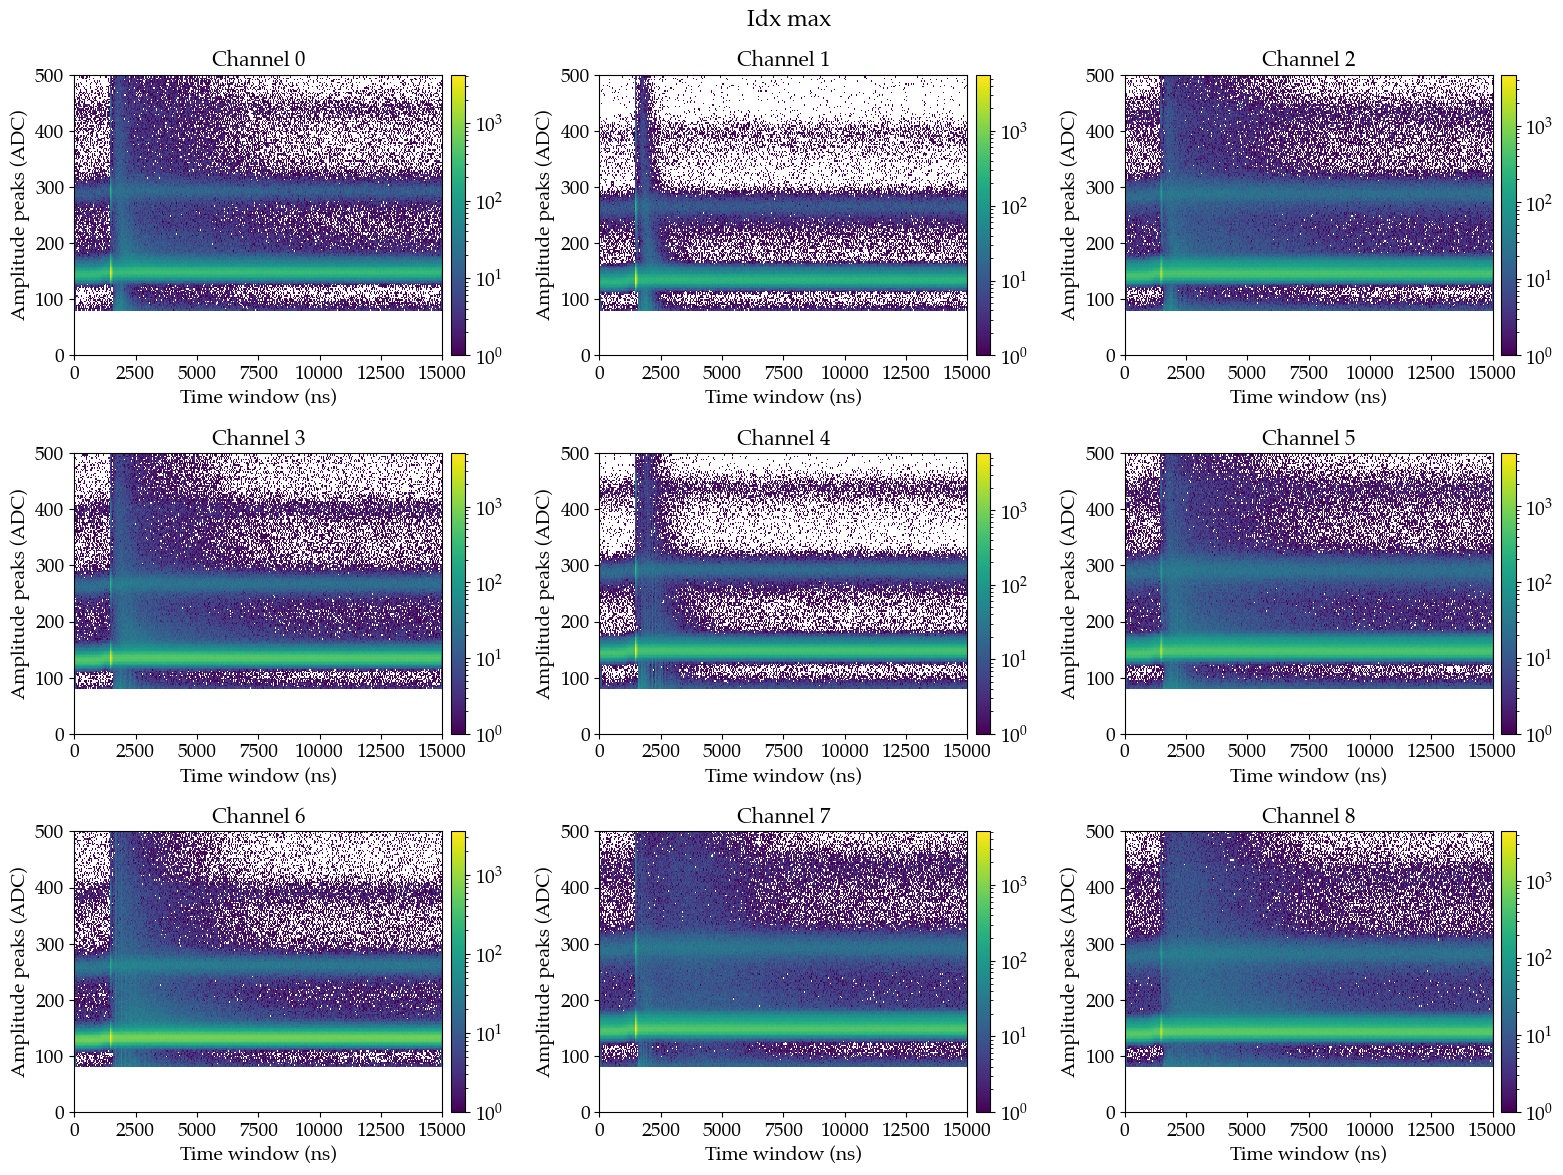

In [9]:
sel_dates = idx_max.keys()
fig, axs  = plt.subplots(3, 3, figsize=(16, 12))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
    
    try:
        ch_idxs = np.concatenate([idx_max  [date][ch] for date in sel_dates])
        ch_vals = np.concatenate([height_sg[date][ch] for date in sel_dates])
    
        fig0 = axs[i][j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 500)), cmin=1, norm=LogNorm())
        axs[i][j].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i][j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i][j].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i][j], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.suptitle('Idx max')
plt.tight_layout()
#plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/hit_maps_pretrigg_and_high_light.pdf', bbox_inches='tight')
plt.show()

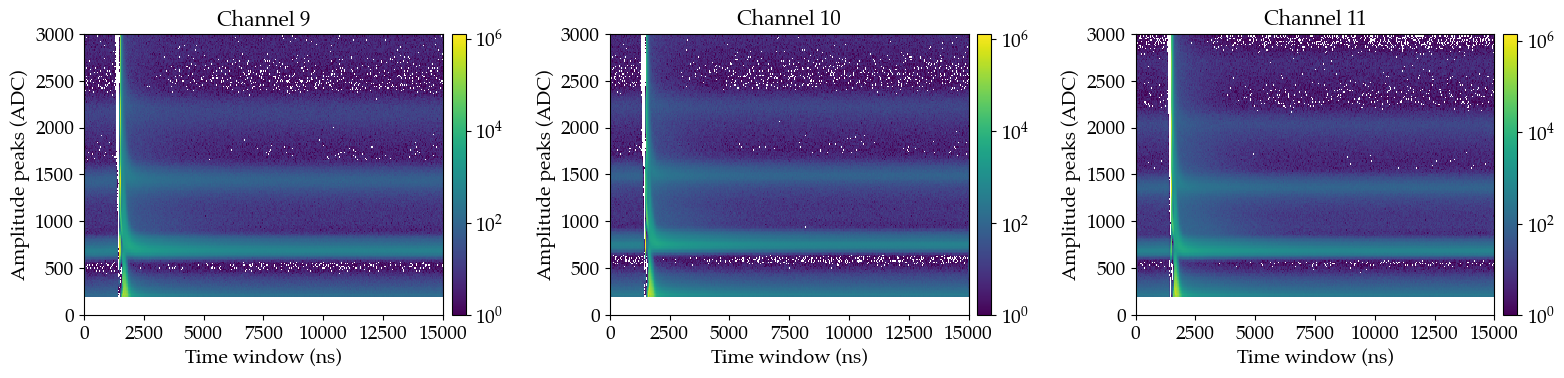

In [10]:
sel_dates = idx_max_trigg.keys()
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i,ch in enumerate(trigger_chs):
    try:
        ch_idxs = np.concatenate([idx_max_trigg  [date][ch] for date in sel_dates])
        ch_vals = np.concatenate([height_sg_trigg[date][ch] for date in sel_dates])
    
        fig0 = axs[i].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 3000)), cmin=1, norm=LogNorm())
        axs[i].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
#plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/hit_maps_pretrigg_and_high_light.pdf', bbox_inches='tight')
plt.show()

#### Compute the survival fraction for each channel

In [11]:
start_time = time.time()

all_wfs_n = {}
for date0 in idx_max_trigg.keys():
    print(date0)
    num_wfs_date = []
    for ifile,filename in enumerate(sorted_files):
        d          = np.load(filename, allow_pickle=True)
        date, fnum = extract_date_and_number(filename)
        if date==date0:
            num_wfs_date.append(len(d['idx_peaks_max_trigg'].item()[9]))
            
    all_wfs_n[date0] = np.sum(np.array(num_wfs_date))
                
end_time     = time.time()                
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

09_10_2024
09_11_2024
09_12_2024
09_20_2024
09_25_2024
09_28_2024
10_04_2024
10_11_2024
10_17_2024
10_25_2024
11_01_2024
11_11_2024
11_25_2024
12_13_2024
12_21_2024
01_02_2025
01_10_2025
01_19_2025
Elapsed time: 87.55566811561584 s, 1.459261135260264 min


In [12]:
sf = {}
for ch in normal_chs:
    sf_ch = {}
    for date in filt_evts_dict.keys():
        sf_ch[date] = len(filt_evts_dict[date][ch])/all_wfs_n[date]
        
    sf[ch] = sf_ch

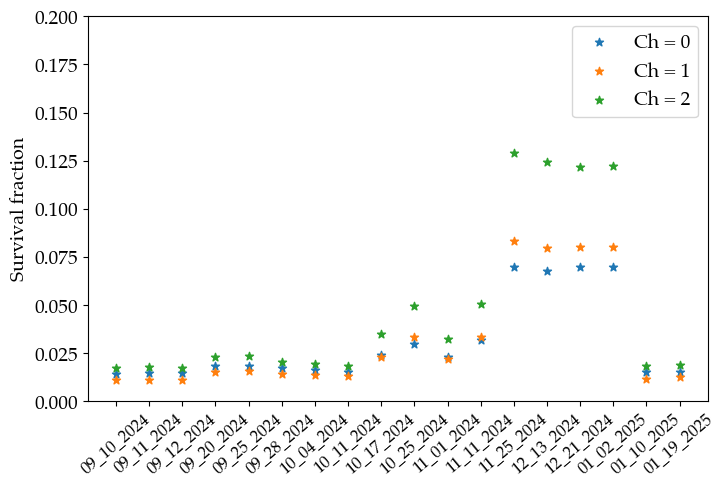

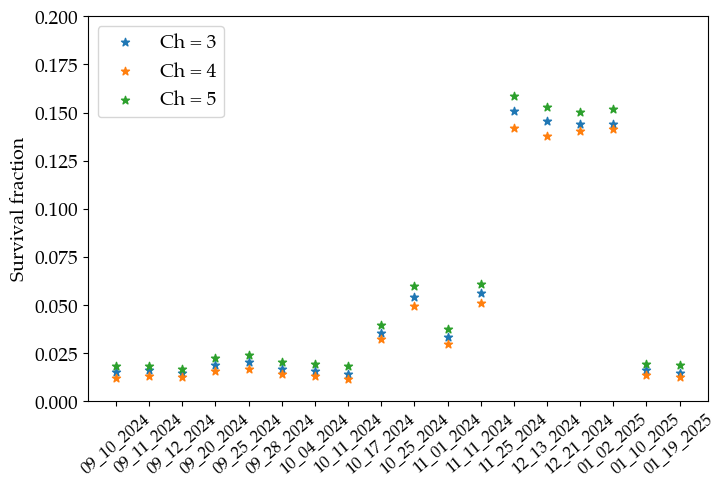

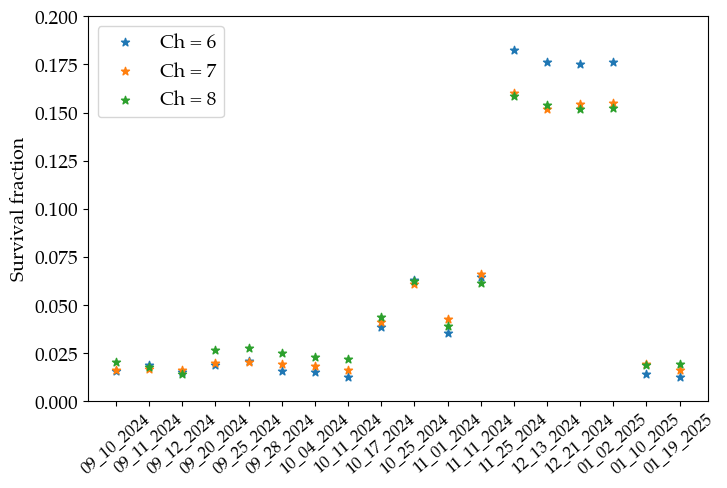

In [13]:
sel_dates = filt_evts_dict.keys()
for gr_chs in np.arange(9).reshape(3, 3):
    plt.figure(figsize=(8, 5))
    for ch in gr_chs:
        all_sf_ch = [sf[ch][date] for date in sel_dates]
        plt.scatter(sel_dates, all_sf_ch, label=f'Ch = {ch}', marker='*')
    plt.tick_params(axis='x', rotation=40, labelsize=12)
    plt.ylabel('Survival fraction')
    plt.ylim(0, 0.2)
    plt.legend()
    plt.show()

In [14]:
def get_t_dist_from_hit_map(timestamps, amplitudes, bin_size=None):
    #bin_size is in time samples. bins_size=20 would be 40 ns
    unique_tmstmp = np.unique(timestamps)
    sum_ampl      = np.array([np.sum(amplitudes[timestamps == timestamp]) for timestamp in unique_tmstmp])
    if bin_size:
        reshaped = sum_ampl[:len(sum_ampl) - len(sum_ampl) % bin_size].reshape(-1, bin_size)
        sum_ampl   = reshaped.sum(axis=1)
        return bin_size*np.arange(len(sum_ampl)), sum_ampl
    else:
        return unique_tmstmp, sum_ampl

In [15]:
sel_dates = idx_max.keys()
uniq_ts   = {}
sum_ampls = {}
for ch in normal_chs:
    print(ch)
    uniq_ts_ch, sum_ampls_ch = get_t_dist_from_hit_map(2*np.concatenate([idx_max  [date][ch] for date in sel_dates]),
                                                         np.concatenate([height_sg[date][ch] for date in sel_dates]))
    uniq_ts  [ch] = uniq_ts_ch
    sum_ampls[ch] = sum_ampls_ch

0
1
2
3
4
5
6
7
8


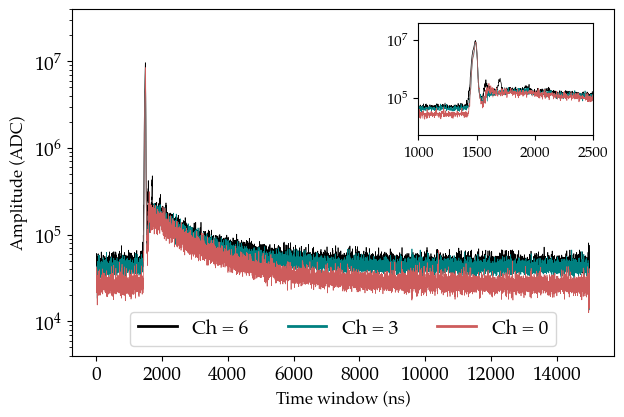

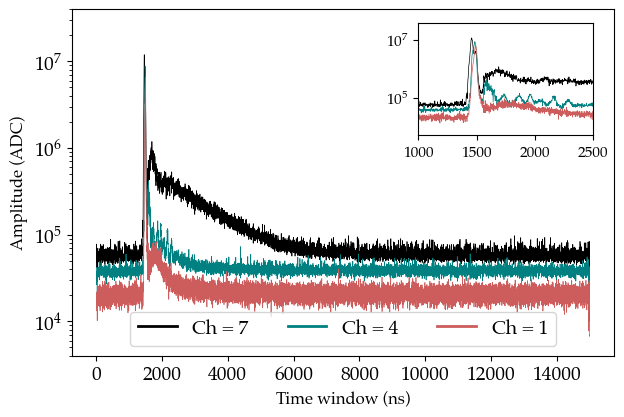

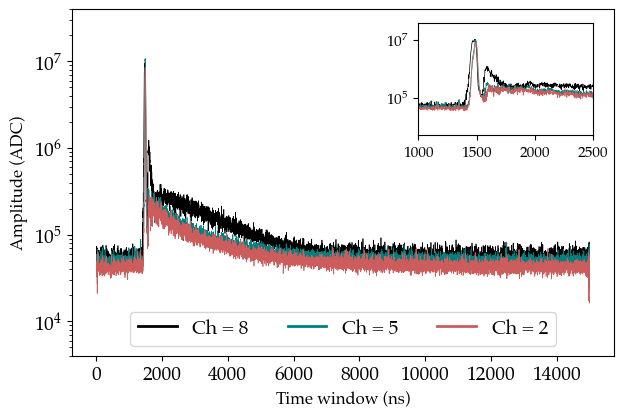

In [16]:
sel_dates = idx_max.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts[ch], sum_ampls[ch]
        plt.plot(unique_tstamps, sum_ampl, lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    plt.ylim(4e3, 4e7)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts[ch], sum_ampls[ch]
        ax_inset.plot(unique_tstamps, sum_ampl, c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    ax_inset.set_ylim(5e3, 4e7)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

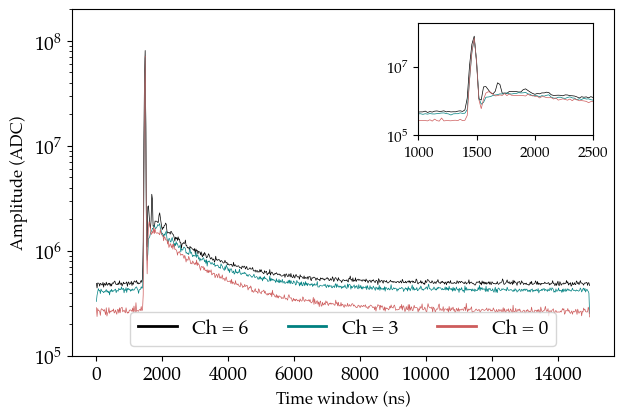

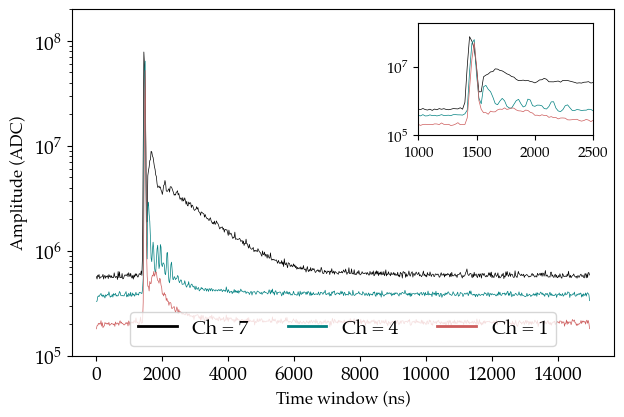

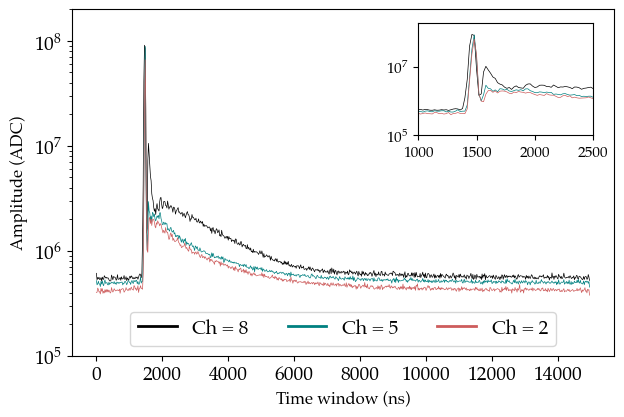

In [17]:
bin_size  = 10 #t sample, 20 ns
sel_dates = idx_max.keys()
for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts[ch], sum_ampls[ch]        
        reshaped = sum_ampl[:len(sum_ampl) - len(sum_ampl) % bin_size].reshape(-1, bin_size)
        summed   = reshaped.sum(axis=1)
        plt.plot(2*bin_size*np.arange(len(summed)), summed, lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)', fontsize=12)
    plt.yscale('log')
    plt.ylim(1e5, 2e8)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts[ch], sum_ampls[ch]        
        reshaped = sum_ampl[:len(sum_ampl) - len(sum_ampl) % bin_size].reshape(-1, bin_size)
        summed   = reshaped.sum(axis=1)
        ax_inset.plot(2*bin_size*np.arange(len(summed)), summed, c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    ax_inset.set_ylim(1e5, 2e8)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

## Remove events before trigger

In [18]:
start_time = time.time()
idx_max_pt   = {}
height_sg_pt = {}
num_evts_pt  = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    for ch in normal_chs:
        idx_after_cut    = []
        height_after_cut = []
        num_evts         = 0
        idx_peaks_ch     = d['idx_peaks_max']  .item()[ch]
        height_peaks_ch  = d['height_peaks_sg'].item()[ch]
        
        for idxs, vals in zip(idx_peaks_ch, height_peaks_ch):
            if len(idxs)==0:
                continue
            noise_evts = (np.array(idxs)<650)&(np.array(vals)>100)
            if np.any(noise_evts):
                continue
            #if np.any(np.array(vals) > 1000):
            #    continue
            else:
                idx_after_cut   .append(idxs)
                height_after_cut.append(vals)
                num_evts += 1
                
        if date not in idx_max_pt:
            print(date)
            idx_max_pt  [date] = {}
            height_sg_pt[date] = {}
            num_evts_pt [date] = {}

        if ch not in idx_max_pt[date]:
            try:
                idx_max_pt  [date][ch] = np.concatenate(idx_after_cut)
                height_sg_pt[date][ch] = np.concatenate(height_after_cut)
                num_evts_pt [date][ch] = np.array([num_evts])
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_max_pt  [date][ch] = np.concatenate((idx_max_pt  [date][ch], np.concatenate(idx_after_cut)))
                height_sg_pt[date][ch] = np.concatenate((height_sg_pt[date][ch], np.concatenate(height_after_cut)))
                num_evts_pt [date][ch] = np.concatenate((num_evts_pt [date][ch], np.array([num_evts])))
            except Exception as e:
                print(e)
                continue

end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1379
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
10_04_2024
300
320
340
360
need at least one array to concatenate
10_11_2024
380
400
420
440
460
10_17_2024
480
500
520
540
560
10_25_2024
580
600
620
640
11_01_2024
660
680
700
720
11_11_2024
740
760
780
800
820
11_25_2024
840
860
880
900
920
12_13_2024
940
960
980
1000
1020
12_21_2024
1040
1060
1080
1100
01_02_2025
1120
1140
1160
1180
1200
01_10_2025
1220
1240
1260
1280
01_19_2025
1300
1320
1340
1360
Elapsed time: 300.5473840236664 s, 5.009123067061107 min


#### Survival fraction after the pretrigger cut:

In [19]:
sf_pt = {}
for ch in normal_chs:
    sf_ch = {}
    for date in filt_evts_dict.keys():
        sf_ch[date] = np.sum(num_evts_pt[date][ch])/len(filt_evts_dict[date][ch])
        
    sf_pt[ch] = sf_ch

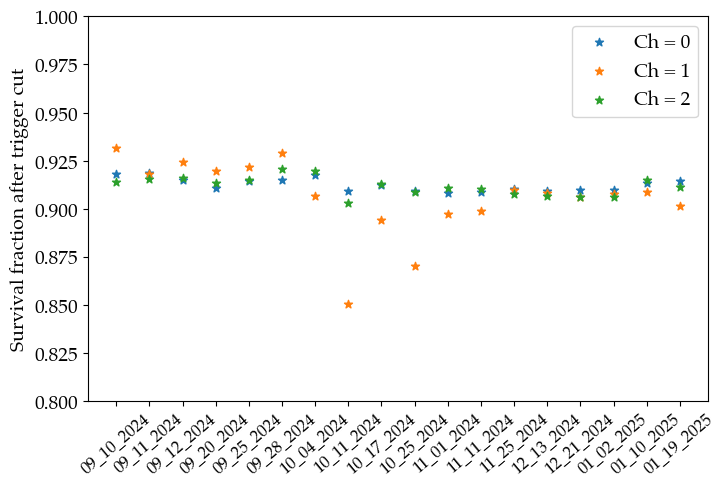

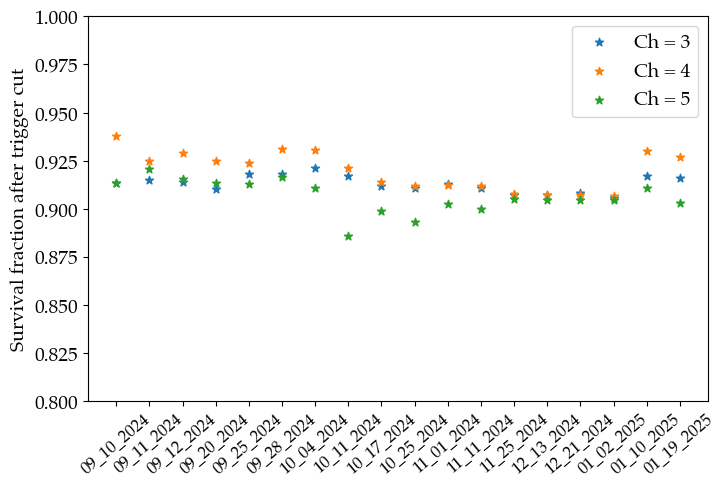

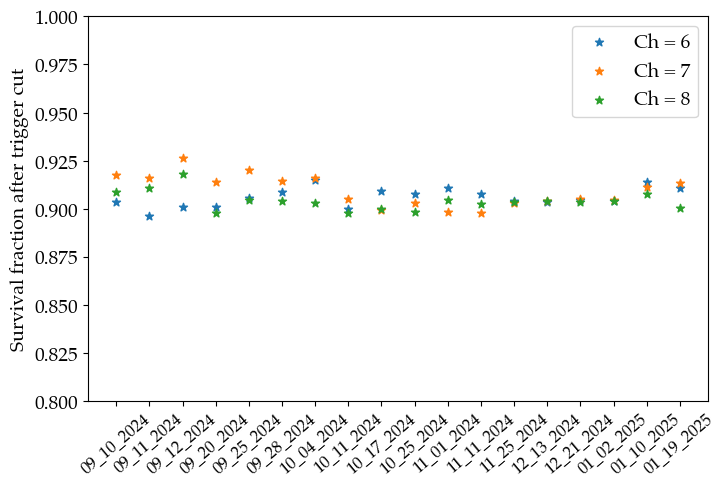

In [20]:
sel_dates = filt_evts_dict.keys()
for gr_chs in np.arange(9).reshape(3, 3):
    plt.figure(figsize=(8, 5))
    for ch in gr_chs:
        all_sf_ch = [sf_pt[ch][date] for date in sel_dates]
        plt.scatter(sel_dates, all_sf_ch, label=f'Ch = {ch}', marker='*')
    plt.tick_params(axis='x', rotation=40, labelsize=12)
    plt.ylabel('Survival fraction after trigger cut')
    plt.ylim(0.8, 1)
    plt.legend()
    plt.show()

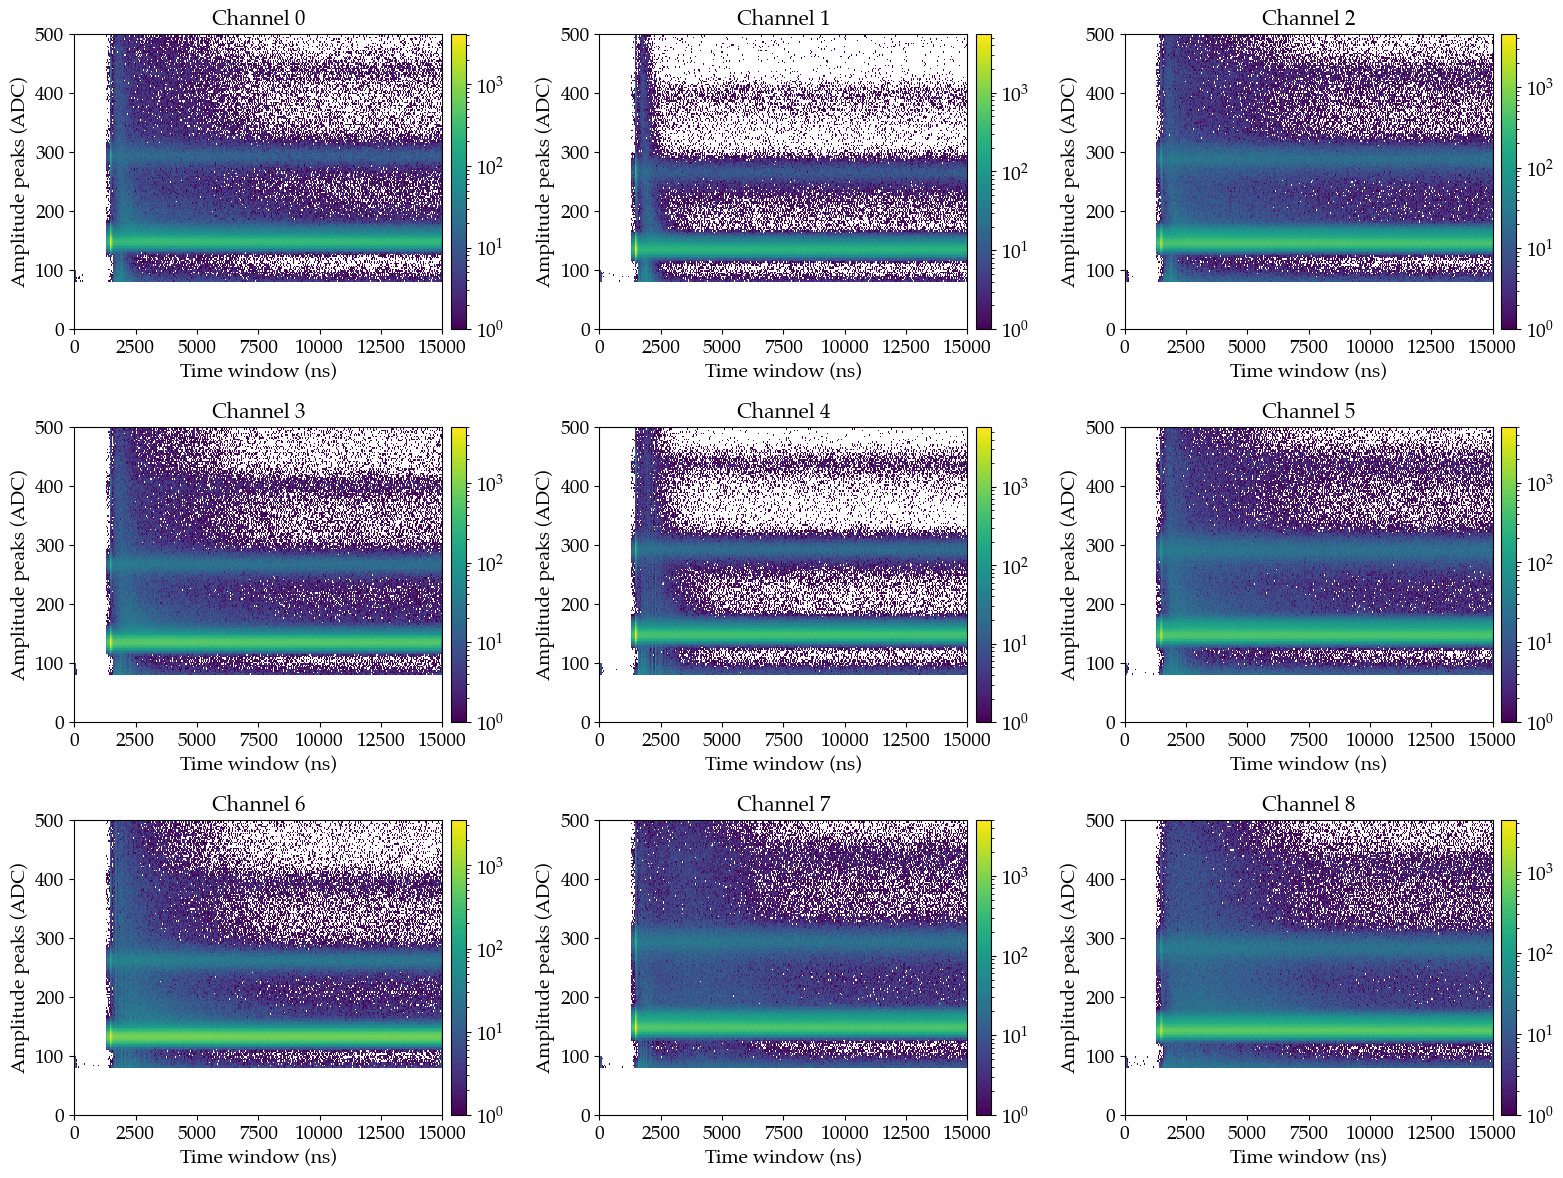

In [21]:
sel_dates = idx_max_pt.keys()
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
    
    try:
        ch_idxs = np.concatenate([idx_max_pt  [date][ch] for date in sel_dates])
        ch_vals = np.concatenate([height_sg_pt[date][ch] for date in sel_dates])
    
        fig0 = axs[i][j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 500)), cmin=1, norm=LogNorm())
        axs[i][j].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i][j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i][j].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i][j], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
#plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/hit_maps_pretrigg_and_high_light.pdf', bbox_inches='tight')
plt.show()

In [22]:
sel_dates = idx_max_pt.keys()
uniq_ts_pt   = {}
sum_ampls_pt = {}
for ch in normal_chs:
    print(ch)
    uniq_ts_ch, sum_ampls_ch = get_t_dist_from_hit_map(2*np.concatenate([idx_max_pt  [date][ch] for date in sel_dates]),
                                                         np.concatenate([height_sg_pt[date][ch] for date in sel_dates]))
    uniq_ts_pt  [ch] = uniq_ts_ch
    sum_ampls_pt[ch] = sum_ampls_ch

0
1
2
3
4
5
6
7
8


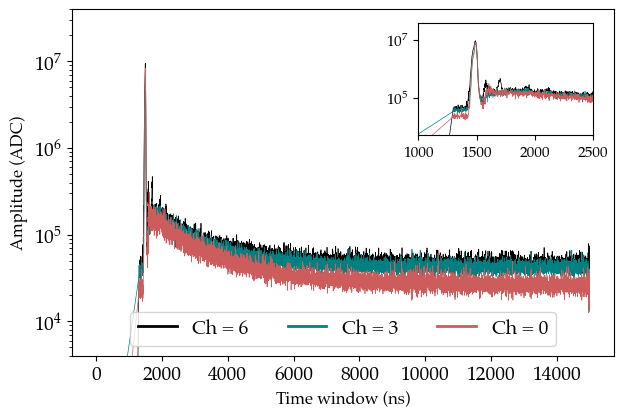

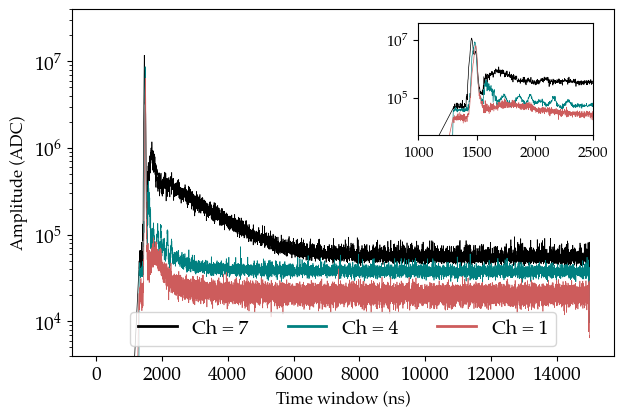

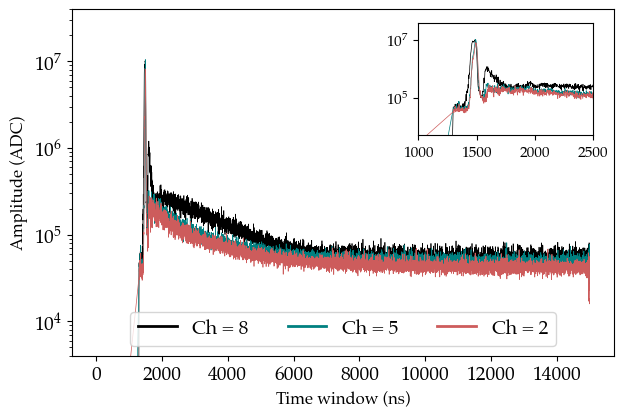

In [23]:
sel_dates = idx_max_pt.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_pt[ch], sum_ampls_pt[ch]
        plt.plot(unique_tstamps, sum_ampl, lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    plt.ylim(4e3, 4e7)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_pt[ch], sum_ampls_pt[ch]
        ax_inset.plot(unique_tstamps, sum_ampl, c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    ax_inset.set_ylim(5e3, 4e7)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

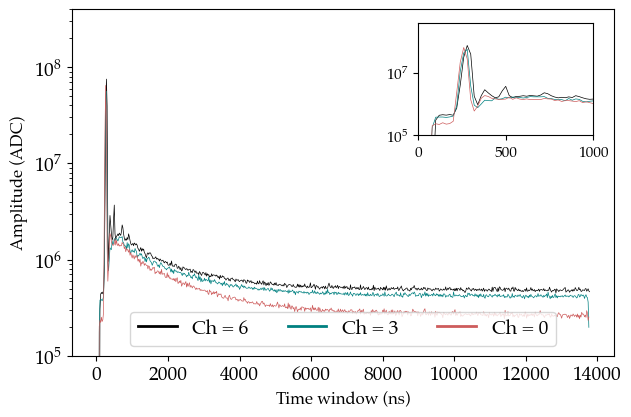

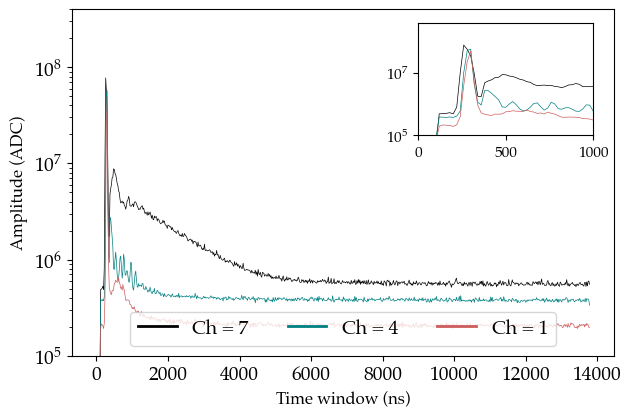

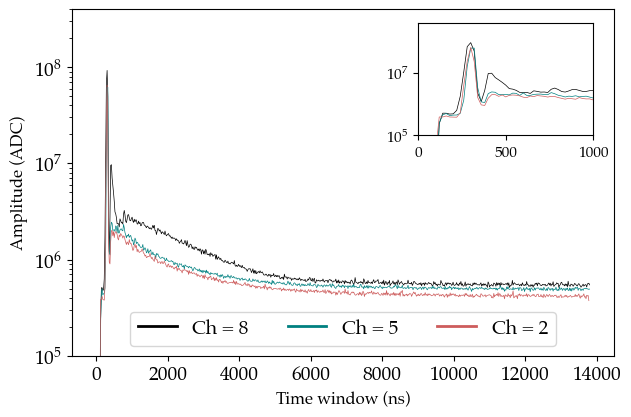

In [24]:
bin_size  = 10 #t sample, 20 ns
sel_dates = idx_max_pt.keys()
for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_pt[ch], sum_ampls_pt[ch]        
        reshaped = sum_ampl[:len(sum_ampl) - len(sum_ampl) % bin_size].reshape(-1, bin_size)
        summed   = reshaped.sum(axis=1)
        plt.plot(2*bin_size*np.arange(len(summed)), summed, lw=0.5, c=col, label=f'Ch = {ch}')

    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    plt.ylim(1e5, 4e8)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_pt[ch], sum_ampls_pt[ch]        
        reshaped = sum_ampl[:len(sum_ampl) - len(sum_ampl) % bin_size].reshape(-1, bin_size)
        summed   = reshaped.sum(axis=1)
        ax_inset.plot(2*bin_size*np.arange(len(summed)), summed, lw=0.5, c=col, label=f'Ch = {ch}')

    ax_inset.set_xlim(0, 1000)
    ax_inset.set_ylim(1e5, 4e8)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

## Trigger SiPMs

In [25]:
sel_dates = idx_max_trigg.keys()
uniq_ts_trigg   = {}
sum_ampls_trigg = {}
for ch in trigger_chs:
    print(ch)
    uniq_ts_ch, sum_ampls_ch = get_t_dist_from_hit_map(2*np.concatenate([idx_max_trigg  [date][ch] for date in sel_dates]),
                                                         np.concatenate([height_sg_trigg[date][ch] for date in sel_dates]))
    uniq_ts_trigg  [ch] = uniq_ts_ch
    sum_ampls_trigg[ch] = sum_ampls_ch

9
10
11


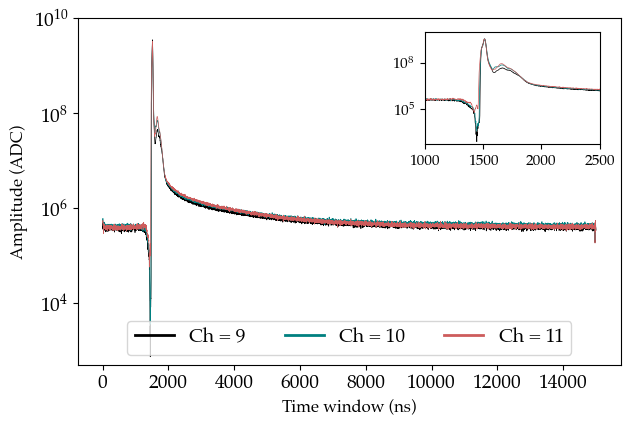

In [26]:
sel_dates = idx_max_trigg.keys()

fig = plt.figure(figsize=(7, 4.5))
for ch, col in zip(trigger_chs, ['k', 'teal', 'indianred']):
    unique_tstamps, sum_ampl = uniq_ts_trigg[ch], sum_ampls_trigg[ch]
    plt.plot(unique_tstamps, sum_ampl, lw=0.5, c=col, label=f'Ch = {ch}')

plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
plt.ylim(5e2, 1e10)
leg = plt.legend(loc='lower center', ncol=3)
for line in leg.get_lines():
    line.set_linewidth(2)

# Inset plot
ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
for ch, col in zip(trigger_chs, ['k', 'teal', 'indianred']):
    unique_tstamps, sum_ampl = uniq_ts_trigg[ch], sum_ampls_trigg[ch]
    ax_inset.plot(unique_tstamps, sum_ampl, c=col, lw=0.5)

ax_inset.set_xlim(1000, 2500)
ax_inset.set_ylim(5e2, 1e10)
ax_inset.tick_params(axis='x', labelsize=11)
ax_inset.tick_params(axis='y', labelsize=11)
ax_inset.set_yscale('log')
plt.show()

### Reject high light events:

In [27]:
start_time = time.time()
idx_max_hl   = {}
height_sg_hl = {}
num_evts_hl  = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    for ch in normal_chs:
        idx_after_cut    = []
        height_after_cut = []
        num_evts         = 0
        idx_peaks_ch     = d['idx_peaks_max']  .item()[ch]
        height_peaks_ch  = d['height_peaks_sg'].item()[ch]
        
        for idxs, vals in zip(idx_peaks_ch, height_peaks_ch):
            if len(idxs)==0:
                continue
            #noise_evts = (np.array(idxs)<650)&(np.array(vals)>100)
            #if np.any(noise_evts):
            #    continue
            if np.any(np.array(vals) > 1000):
                continue
            else:
                idx_after_cut   .append(idxs)
                height_after_cut.append(vals)
                num_evts += 1
                
        if date not in idx_max_hl:
            print(date)
            idx_max_hl  [date] = {}
            height_sg_hl[date] = {}
            num_evts_hl [date] = {}

        if ch not in idx_max_hl[date]:
            try:
                idx_max_hl  [date][ch] = np.concatenate(idx_after_cut)
                height_sg_hl[date][ch] = np.concatenate(height_after_cut)
                num_evts_hl [date][ch] = np.array([num_evts])
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_max_hl  [date][ch] = np.concatenate((idx_max_hl  [date][ch], np.concatenate(idx_after_cut)))
                height_sg_hl[date][ch] = np.concatenate((height_sg_hl[date][ch], np.concatenate(height_after_cut)))
                num_evts_hl [date][ch] = np.concatenate((num_evts_hl [date][ch], np.array([num_evts])))
            except Exception as e:
                print(e)
                continue

end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1379
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
10_04_2024
300
320
340
360
need at least one array to concatenate
10_11_2024
380
400
420
440
460
10_17_2024
480
500
520
540
560
10_25_2024
580
600
620
640
11_01_2024
660
680
700
720
11_11_2024
740
760
780
800
820
11_25_2024
840
860
880
900
920
12_13_2024
940
960
980
1000
1020
12_21_2024
1040
1060
1080
1100
01_02_2025
1120
1140
1160
1180
1200
01_10_2025
1220
1240
1260
1280
01_19_2025
1300
1320
1340
1360
Elapsed time: 288.02531003952026 s, 4.800421833992004 min


In [28]:
sf_hl = {}
for ch in normal_chs:
    sf_ch = {}
    for date in filt_evts_dict.keys():
        sf_ch[date] = np.sum(num_evts_hl[date][ch])/len(filt_evts_dict[date][ch])
        
    sf_hl[ch] = sf_ch

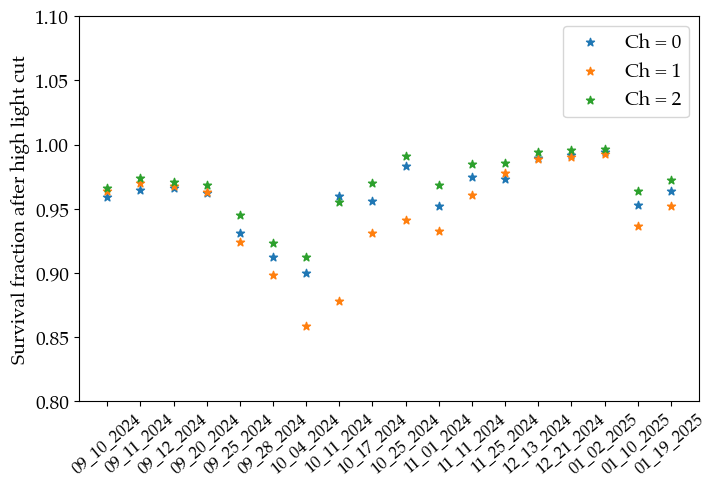

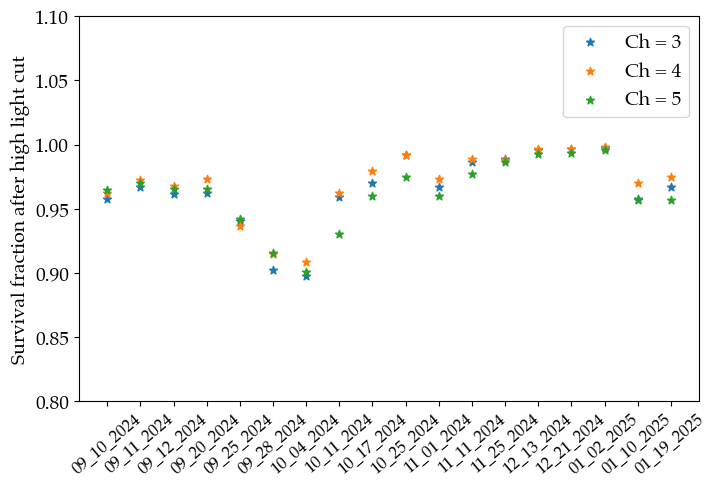

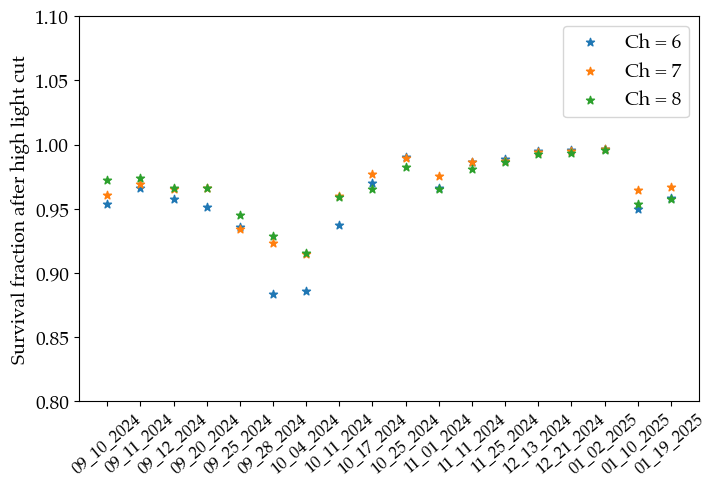

In [29]:
sel_dates = filt_evts_dict.keys()
for gr_chs in np.arange(9).reshape(3, 3):
    plt.figure(figsize=(8, 5))
    for ch in gr_chs:
        all_sf_ch = [sf_hl[ch][date] for date in sel_dates]
        plt.scatter(sel_dates, all_sf_ch, label=f'Ch = {ch}', marker='*')
    plt.tick_params(axis='x', rotation=40, labelsize=12)
    plt.ylabel('Survival fraction after high light cut')
    plt.ylim(0.8, 1.1)
    plt.legend()
    plt.show()

In [30]:
sel_dates = idx_max_hl.keys()
uniq_ts_hl   = {}
sum_ampls_hl = {}
for ch in normal_chs:
    print(ch)
    uniq_ts_ch, sum_ampls_ch = get_t_dist_from_hit_map(2*np.concatenate([idx_max_hl  [date][ch] for date in sel_dates]),
                                                         np.concatenate([height_sg_hl[date][ch] for date in sel_dates]))
    uniq_ts_hl  [ch] = uniq_ts_ch
    sum_ampls_hl[ch] = sum_ampls_ch

0
1
2
3
4
5
6
7
8


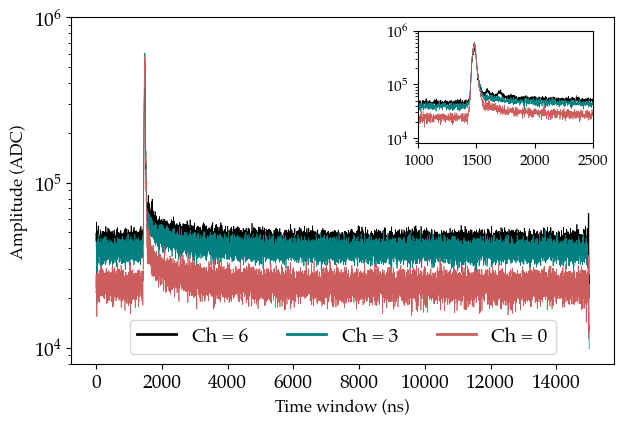

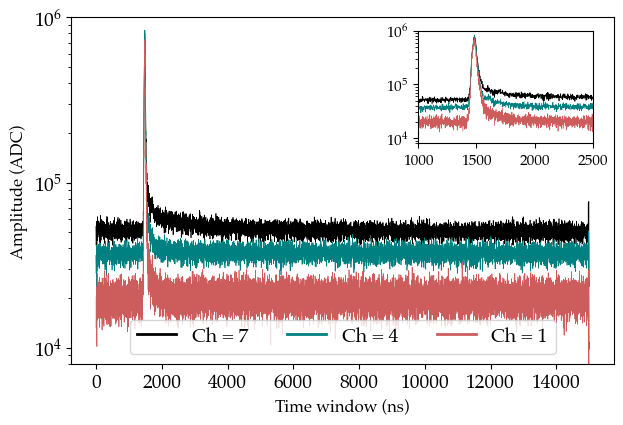

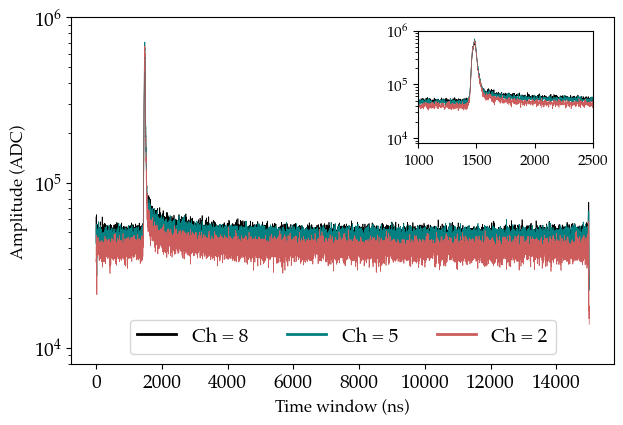

In [31]:
sel_dates = idx_max_hl.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_hl[ch], sum_ampls_hl[ch]
        plt.plot(unique_tstamps, sum_ampl, lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    plt.ylim(8e3, 1e6)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_hl[ch], sum_ampls_hl[ch]
        ax_inset.plot(unique_tstamps, sum_ampl, c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    ax_inset.set_ylim(8e3, 1e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

## Try looking at the events above 1000 ADC because the triplet is not seen anymore

In [32]:
start_time = time.time()
idx_max_hl2   = {}
height_sg_hl2 = {}
num_evts_hl2  = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    for ch in normal_chs:
        idx_after_cut    = []
        height_after_cut = []
        num_evts         = 0
        idx_peaks_ch     = d['idx_peaks_max']  .item()[ch]
        height_peaks_ch  = d['height_peaks_sg'].item()[ch]
        
        for idxs, vals in zip(idx_peaks_ch, height_peaks_ch):
            if len(idxs)==0:
                continue
            #noise_evts = (np.array(idxs)<650)&(np.array(vals)>100)
            #if np.any(noise_evts):
            #    continue
            if np.any(np.array(vals) > 1000):
                idx_after_cut   .append(idxs)
                height_after_cut.append(vals)
                num_evts += 1
            else:
                continue
                
        if date not in idx_max_hl2:
            print(date)
            idx_max_hl2  [date] = {}
            height_sg_hl2[date] = {}
            num_evts_hl2 [date] = {}

        if ch not in idx_max_hl2[date]:
            try:
                idx_max_hl2  [date][ch] = np.concatenate(idx_after_cut)
                height_sg_hl2[date][ch] = np.concatenate(height_after_cut)
                num_evts_hl2 [date][ch] = np.array([num_evts])
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_max_hl2  [date][ch] = np.concatenate((idx_max_hl2  [date][ch], np.concatenate(idx_after_cut)))
                height_sg_hl2[date][ch] = np.concatenate((height_sg_hl2[date][ch], np.concatenate(height_after_cut)))
                num_evts_hl2 [date][ch] = np.concatenate((num_evts_hl2 [date][ch], np.array([num_evts])))
            except Exception as e:
                print(e)
                continue

end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1379
0
09_10_2024
need at least one array to concatenate
09_11_2024
20
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
40
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
09_12_2024
need at least one array to concatenate
need at least one array to concatenate
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
10_04_2024
300
320
340
360
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
10_11_2024
380
400
420
440
460
10_17_2024
480
500
520
540
560
10_25_2024
need at least one array to concate

In [33]:
sf_hl2 = {}
for ch in normal_chs:
    sf_ch = {}
    for date in filt_evts_dict.keys():
        sf_ch[date] = np.sum(num_evts_hl2[date][ch])/len(filt_evts_dict[date][ch])
        
    sf_hl2[ch] = sf_ch

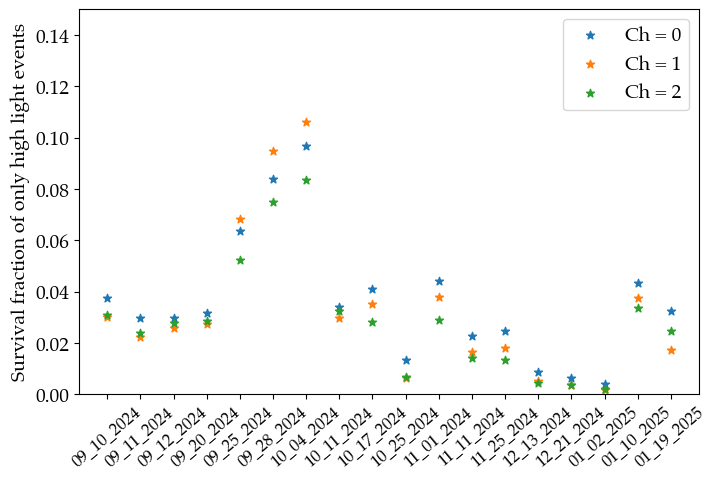

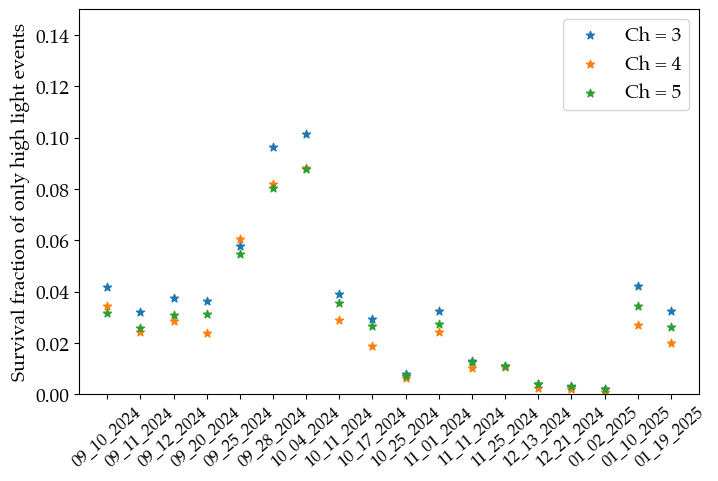

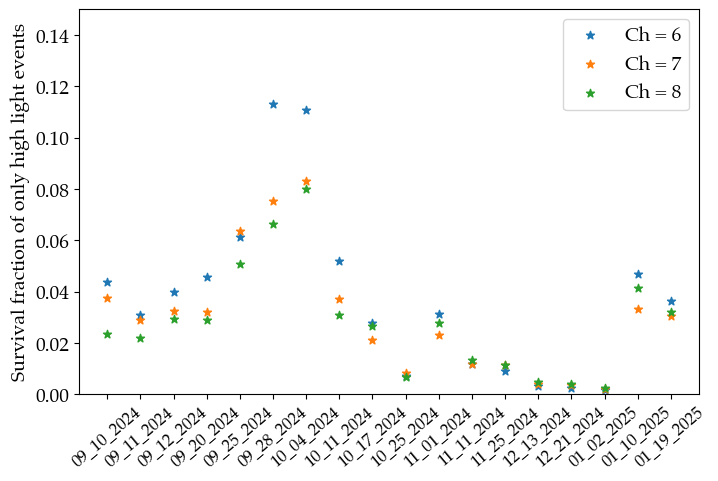

In [34]:
sel_dates = filt_evts_dict.keys()
for gr_chs in np.arange(9).reshape(3, 3):
    plt.figure(figsize=(8, 5))
    for ch in gr_chs:
        all_sf_ch = [sf_hl2[ch][date] for date in sel_dates]
        plt.scatter(sel_dates, all_sf_ch, label=f'Ch = {ch}', marker='*')
    plt.tick_params(axis='x', rotation=40, labelsize=12)
    plt.ylabel('Survival fraction of only high light events')
    plt.ylim(0, 0.15)
    plt.legend()
    plt.show()

In [35]:
sel_dates = idx_max_hl2.keys()
uniq_ts_hl2   = {}
sum_ampls_hl2 = {}
for ch in normal_chs:
    print(ch)
    uniq_ts_ch, sum_ampls_ch = get_t_dist_from_hit_map(2*np.concatenate([idx_max_hl2  [date][ch] for date in sel_dates]),
                                                         np.concatenate([height_sg_hl2[date][ch] for date in sel_dates]))
    uniq_ts_hl2  [ch] = uniq_ts_ch
    sum_ampls_hl2[ch] = sum_ampls_ch

0
1
2
3
4
5
6
7
8


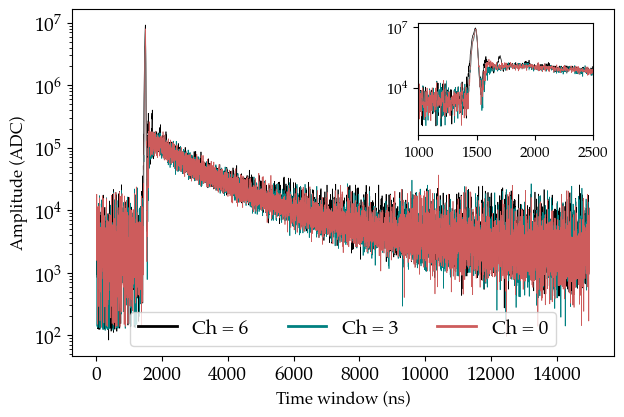

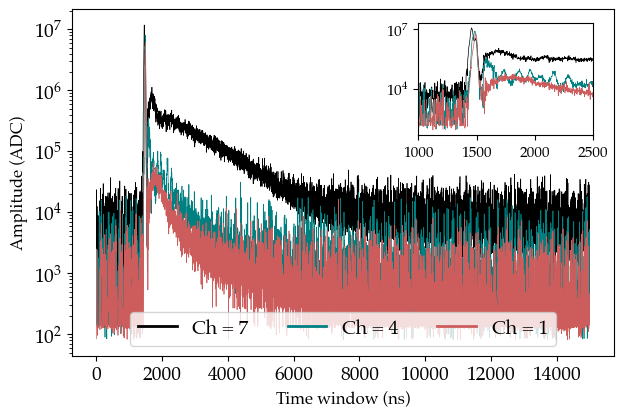

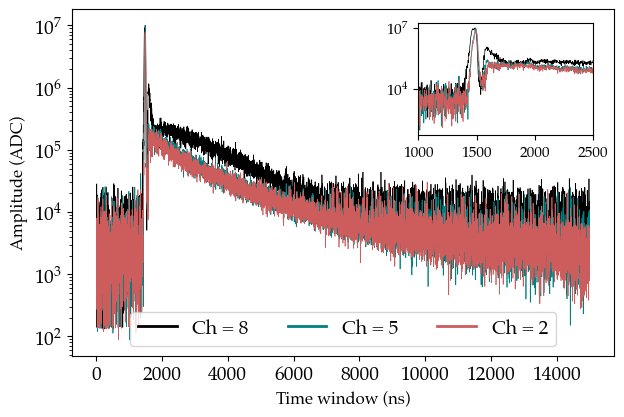

In [125]:
sel_dates = idx_max_hl2.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_hl2[ch], sum_ampls_hl2[ch]
        plt.plot(unique_tstamps, sum_ampl, lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    #plt.ylim(8e3, 1e6)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_hl2[ch], sum_ampls_hl2[ch]
        ax_inset.plot(unique_tstamps, sum_ampl, c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    #ax_inset.set_ylim(8e3, 1e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

## Keep only peaks > 1000 ADC (and other ampls), but not all the peaks of the event

In [153]:
start_time = time.time()
idx_max_hl3   = {}
height_sg_hl3 = {}
idx_max_hl4   = {}
height_sg_hl4 = {}
idx_max_hl5   = {}
height_sg_hl5 = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    for ch in normal_chs:
        idx_after_cut1    = []
        height_after_cut1 = []
        idx_after_cut2    = []
        height_after_cut2 = []
        idx_after_cut3    = []
        height_after_cut3 = []
        idx_peaks_ch      = d['idx_peaks_max']  .item()[ch]
        height_peaks_ch   = d['height_peaks_sg'].item()[ch]
        
        for idxs, vals in zip(idx_peaks_ch, height_peaks_ch):
            if len(idxs)==0:
                continue
            if np.any(vals > 1000):
                idx_after_cut1   .append(idxs[vals>1000])
                height_after_cut1.append(vals[vals>1000])
            if np.any(vals > 2000):
                idx_after_cut2   .append(idxs[vals>2000])
                height_after_cut2.append(vals[vals>2000])
            if np.any(vals > 500):
                idx_after_cut3   .append(idxs[vals>500])
                height_after_cut3.append(vals[vals>500])
                
        if date not in idx_max_hl3:
            print(date)
            idx_max_hl3  [date] = {}
            height_sg_hl3[date] = {}
            idx_max_hl4  [date] = {}
            height_sg_hl4[date] = {}
            idx_max_hl5  [date] = {}
            height_sg_hl5[date] = {}

        if ch not in idx_max_hl3[date]:
            try:
                idx_max_hl3  [date][ch] = np.concatenate(idx_after_cut1)
                height_sg_hl3[date][ch] = np.concatenate(height_after_cut1)
                idx_max_hl4  [date][ch] = np.concatenate(idx_after_cut2)
                height_sg_hl4[date][ch] = np.concatenate(height_after_cut2)
                idx_max_hl5  [date][ch] = np.concatenate(idx_after_cut3)
                height_sg_hl5[date][ch] = np.concatenate(height_after_cut3)
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_max_hl3  [date][ch] = np.concatenate((idx_max_hl3  [date][ch], np.concatenate(idx_after_cut1)))
                height_sg_hl3[date][ch] = np.concatenate((height_sg_hl3[date][ch], np.concatenate(height_after_cut1)))
                idx_max_hl4  [date][ch] = np.concatenate((idx_max_hl4  [date][ch], np.concatenate(idx_after_cut2)))
                height_sg_hl4[date][ch] = np.concatenate((height_sg_hl4[date][ch], np.concatenate(height_after_cut2)))
                idx_max_hl5  [date][ch] = np.concatenate((idx_max_hl5  [date][ch], np.concatenate(idx_after_cut3)))
                height_sg_hl5[date][ch] = np.concatenate((height_sg_hl5[date][ch], np.concatenate(height_after_cut3)))
            except Exception as e:
                print(e)
                continue

end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1379
0
09_10_2024
need at least one array to concatenate
1
1
need at least one array to concatenate
1
1
1
1
1
need at least one array to concatenate
1
need at least one array to concatenate
1
1
1
1
1
1
1
1
09_11_2024
20
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
40
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
09_12_2024
need at least one array to concatenate
need at least one array to concatenate
need at least one array t

need at least one array to concatenate
1220
need at least one array to concatenate
1240
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
1260
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
1280
01_19_2025
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
1300
need at least one array to concatenate
need at least one array to c

In [154]:
sel_dates = idx_max_hl3.keys()
uniq_ts_hl3   = {}
sum_ampls_hl3 = {}
uniq_ts_hl4   = {}
sum_ampls_hl4 = {}
uniq_ts_hl5   = {}
sum_ampls_hl5 = {}
for ch in normal_chs:
    print(ch)
    uniq_ts_ch1, sum_ampls_ch1 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_hl3  [date][ch] for date in sel_dates if ch in idx_max_hl3  [date].keys()]),
                                                           np.concatenate([height_sg_hl3[date][ch] for date in sel_dates if ch in height_sg_hl3[date].keys()]))
    uniq_ts_ch2, sum_ampls_ch2 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_hl4  [date][ch] for date in sel_dates if ch in idx_max_hl4  [date].keys()]),
                                                           np.concatenate([height_sg_hl4[date][ch] for date in sel_dates if ch in height_sg_hl4[date].keys()]))
    uniq_ts_ch3, sum_ampls_ch3 = get_t_dist_from_hit_map(2*np.concatenate([idx_max_hl5  [date][ch] for date in sel_dates if ch in idx_max_hl5  [date].keys()]),
                                                           np.concatenate([height_sg_hl5[date][ch] for date in sel_dates if ch in height_sg_hl5[date].keys()]))
    uniq_ts_hl3  [ch] = uniq_ts_ch1
    uniq_ts_hl4  [ch] = uniq_ts_ch2
    uniq_ts_hl5  [ch] = uniq_ts_ch3
    sum_ampls_hl3[ch] = sum_ampls_ch1
    sum_ampls_hl4[ch] = sum_ampls_ch2
    sum_ampls_hl5[ch] = sum_ampls_ch3

0
1
2
3
4
5
6
7
8


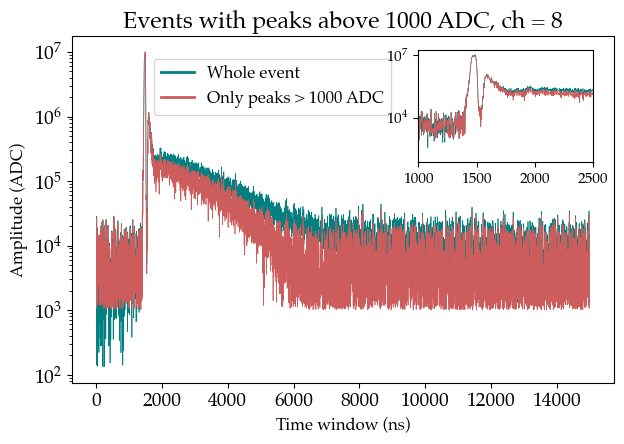

In [175]:
sel_dates = idx_max_hl3.keys()

ch = 8
fig = plt.figure(figsize=(7, 4.5))
unique_tstamps, sum_ampl = uniq_ts_hl2[ch], sum_ampls_hl2[ch]
plt.plot(unique_tstamps, sum_ampl, lw=0.5, c='teal', label=f'Whole event')
unique_tstamps, sum_ampl = uniq_ts_hl3[ch], sum_ampls_hl3[ch]
plt.plot(unique_tstamps, sum_ampl, lw=0.5, c='indianred', label=f'Only peaks > 1000 ADC')
    
plt.title(f'Events with peaks above 1000 ADC, ch = {ch}')
plt.xlabel('Time window (ns)', fontsize=12)
plt.ylabel('Amplitude (ADC)',  fontsize=12)
plt.yscale('log')
#plt.ylim(8e3, 1e6)
leg = plt.legend(loc='lower center', bbox_to_anchor=(0.37, 0.75), fontsize=12)
for line in leg.get_lines():
    line.set_linewidth(2)

# Inset plot
ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
unique_tstamps, sum_ampl = uniq_ts_hl2[ch], sum_ampls_hl2[ch]
ax_inset.plot(unique_tstamps, sum_ampl, lw=0.5, c='teal')
unique_tstamps, sum_ampl = uniq_ts_hl3[ch], sum_ampls_hl3[ch]
ax_inset.plot(unique_tstamps, sum_ampl, lw=0.5, c='indianred')

ax_inset.set_xlim(1000, 2500)
#ax_inset.set_ylim(8e3, 1e6)
ax_inset.tick_params(axis='x', labelsize=11)
ax_inset.tick_params(axis='y', labelsize=11)
ax_inset.set_yscale('log')
plt.show()

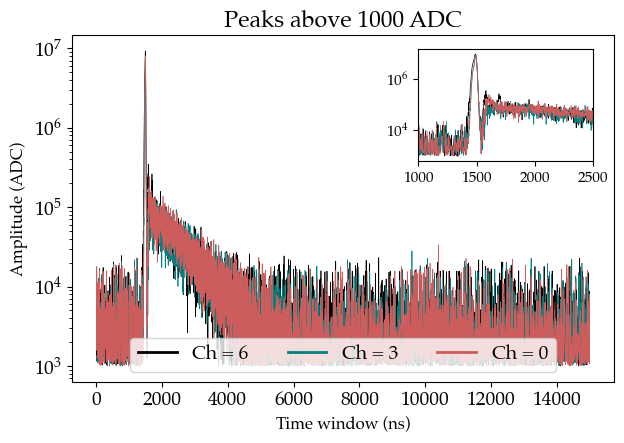

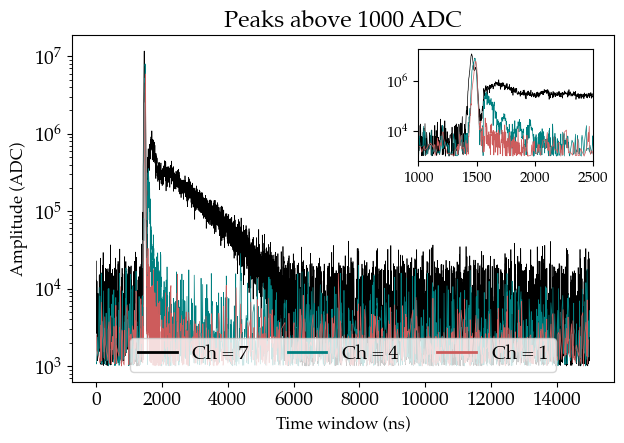

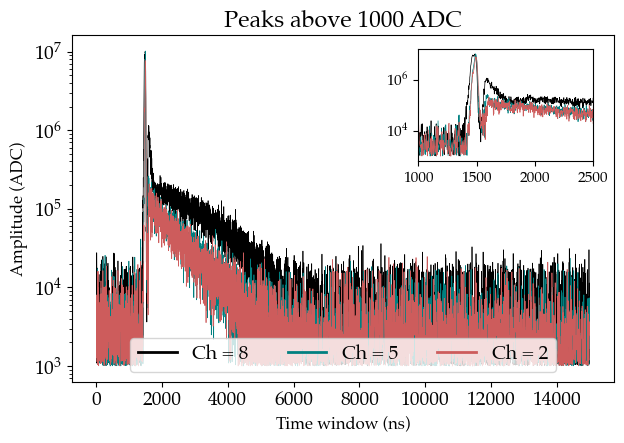

In [156]:
sel_dates = idx_max_hl3.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_hl3[ch], sum_ampls_hl3[ch]
        plt.plot(unique_tstamps, sum_ampl, lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.title('Peaks above 1000 ADC')
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    #plt.ylim(8e3, 1e6)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_hl3[ch], sum_ampls_hl3[ch]
        ax_inset.plot(unique_tstamps, sum_ampl, c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    #ax_inset.set_ylim(8e3, 1e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

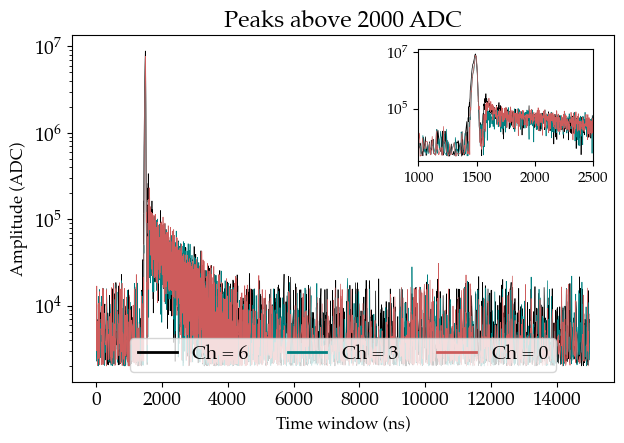

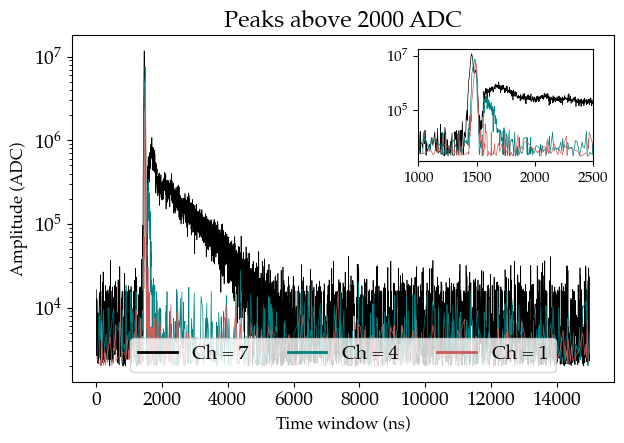

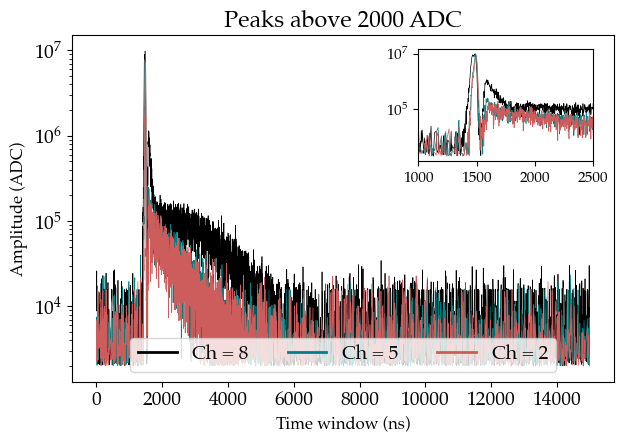

In [157]:
sel_dates = idx_max_hl4.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_hl4[ch], sum_ampls_hl4[ch]
        plt.plot(unique_tstamps, sum_ampl, lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.title('Peaks above 2000 ADC')
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    #plt.ylim(8e3, 1e6)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_hl4[ch], sum_ampls_hl4[ch]
        ax_inset.plot(unique_tstamps, sum_ampl, c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    #ax_inset.set_ylim(8e3, 1e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

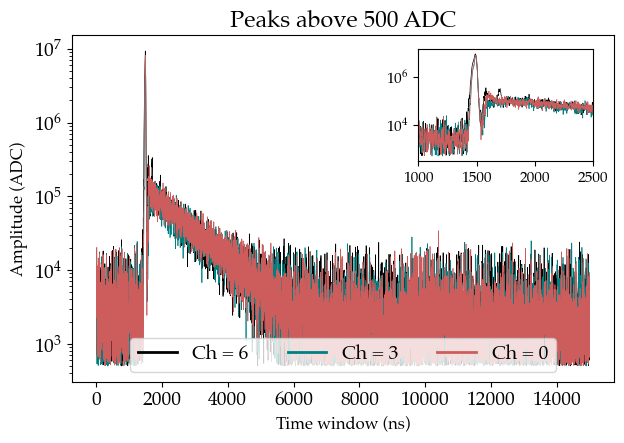

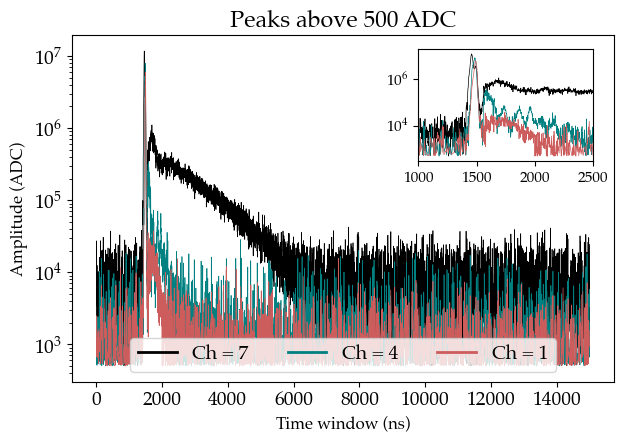

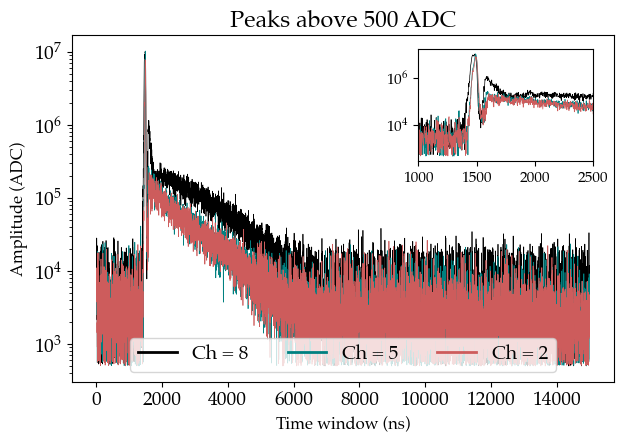

In [158]:
sel_dates = idx_max_hl5.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_hl5[ch], sum_ampls_hl5[ch]
        plt.plot(unique_tstamps, sum_ampl, lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.title('Peaks above 500 ADC')
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    #plt.ylim(8e3, 1e6)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_hl5[ch], sum_ampls_hl5[ch]
        ax_inset.plot(unique_tstamps, sum_ampl, c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    #ax_inset.set_ylim(8e3, 1e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

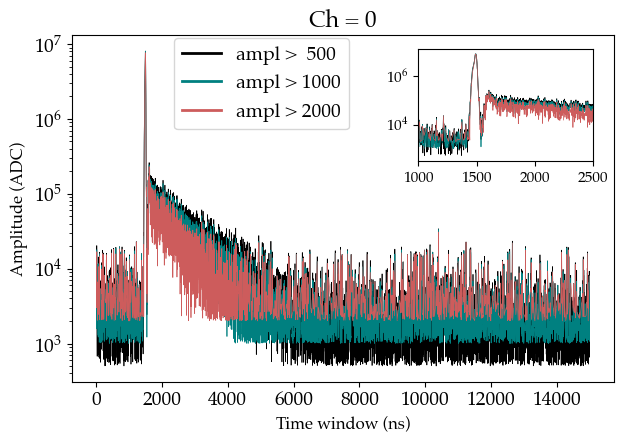

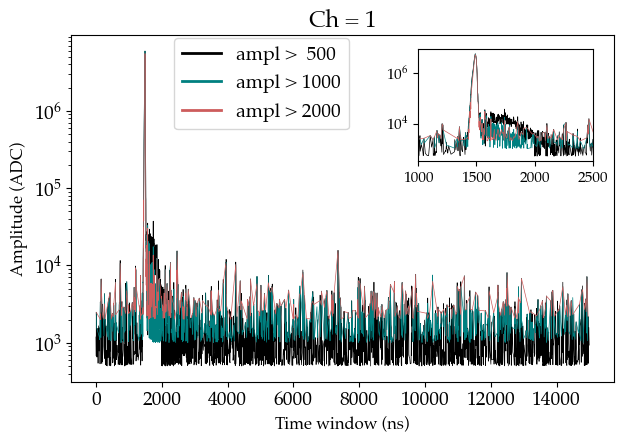

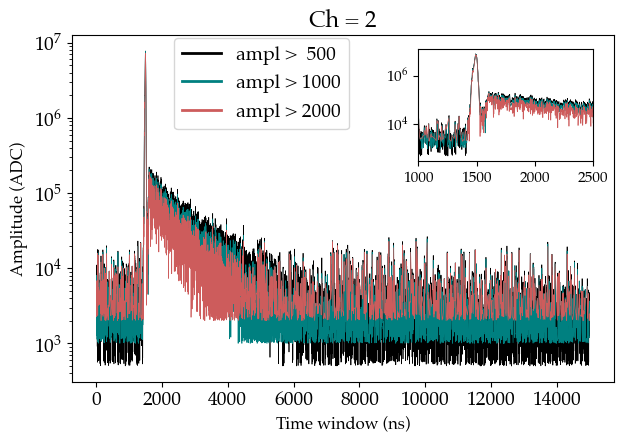

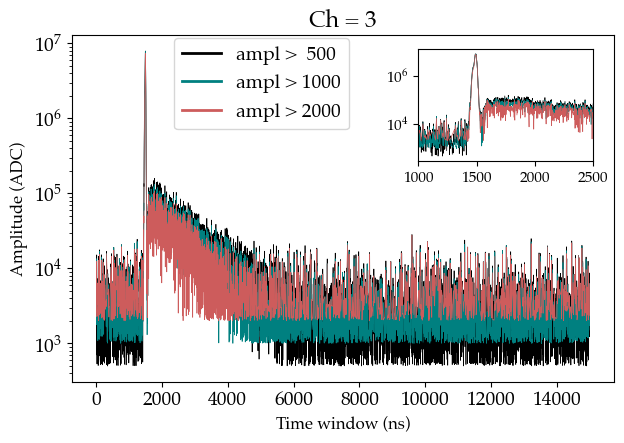

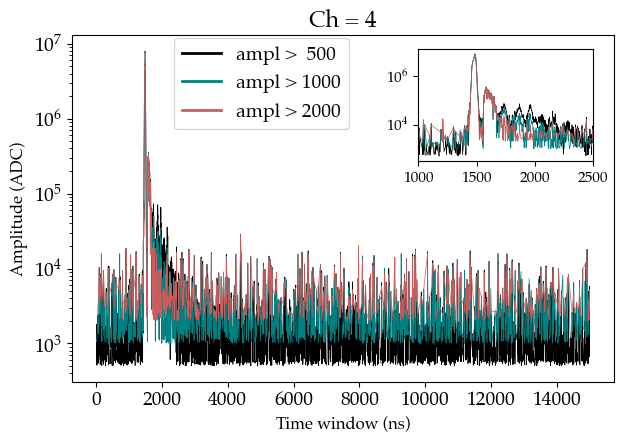

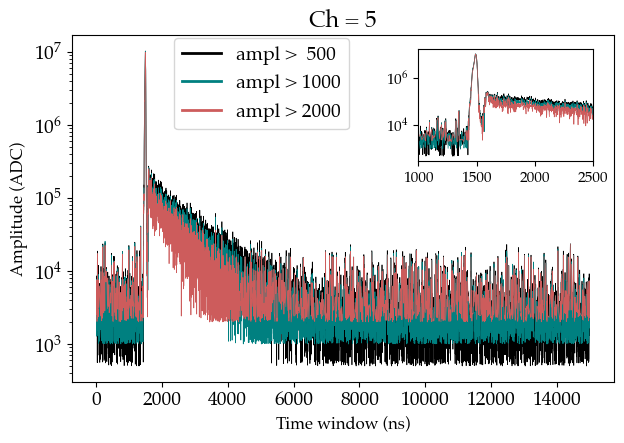

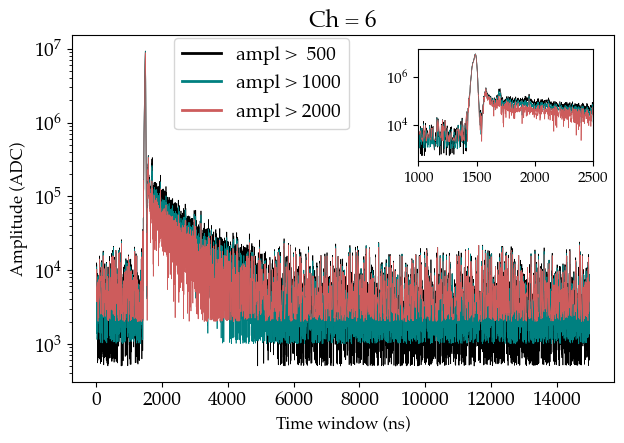

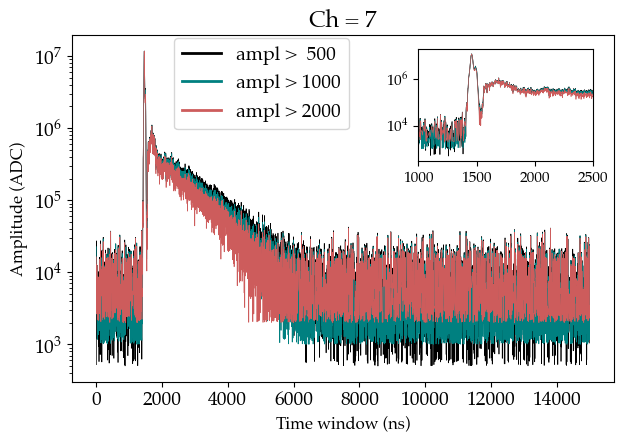

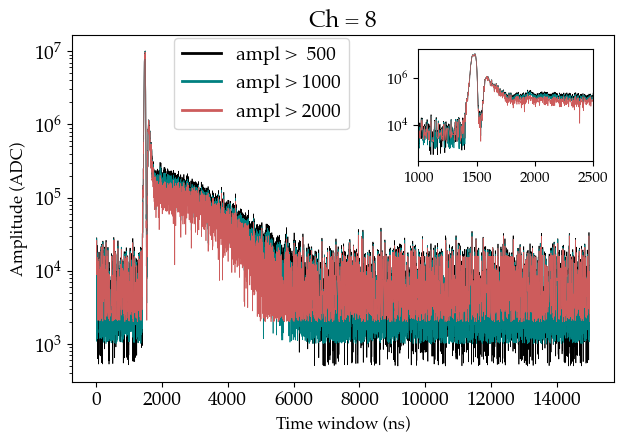

In [163]:
sel_dates = idx_max_hl5.keys()

for ch in normal_chs:
    fig = plt.figure(figsize=(7, 4.5))
    plt.plot(uniq_ts_hl5[ch], sum_ampls_hl5[ch], lw=0.5, c='k',         label=f'ampl >  500')
    plt.plot(uniq_ts_hl3[ch], sum_ampls_hl3[ch], lw=0.5, c='teal',      label=f'ampl > 1000')
    plt.plot(uniq_ts_hl4[ch], sum_ampls_hl4[ch], lw=0.5, c='indianred', label=f'ampl > 2000')
    
    plt.title(f'Ch = {ch}')
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    #plt.ylim(8e3, 1e6)
    leg = plt.legend(loc='lower center', bbox_to_anchor=(0.35, 0.7))
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    ax_inset.plot(uniq_ts_hl5[ch], sum_ampls_hl5[ch], lw=0.5, c='k',         label=f'ampl >  500')
    ax_inset.plot(uniq_ts_hl3[ch], sum_ampls_hl3[ch], lw=0.5, c='teal',      label=f'ampl > 1000')
    ax_inset.plot(uniq_ts_hl4[ch], sum_ampls_hl4[ch], lw=0.5, c='indianred', label=f'ampl > 2000')

    ax_inset.set_xlim(1000, 2500)
    #ax_inset.set_ylim(8e3, 1e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

### Look at the waveforms of events > 1000 ADC

In [246]:
evts_above_1000_dict = {}
for date0 in idx_max_hl5.keys():
    print(date0)
    evts_above_1000 = []
    for filename in sorted_files:
        d = np.load(filename, allow_pickle=True)
        date, fnum = extract_date_and_number(filename)
        if date0 == date:
            idx_peaks_ch_dict    = d['idx_peaks_max']  .item()
            height_peaks_ch_dict = d['height_peaks_sg'].item()
            f_evts_ch_dict       = d['filt_evts_dict'] .item()
            for ch in normal_chs:
                for idxs, vals, evt_no in zip(idx_peaks_ch_dict[ch], height_peaks_ch_dict[ch], f_evts_ch_dict[ch]):
                    if len(idxs)!=0 and np.any(vals > 1000):  # Check if idxs is non-empty and any value in vals > 1000
                        evts_above_1000.append(adapt_evt_id(evt_no, fnum))

    evts_above_1000_dict[date0] = np.array(evts_above_1000)

09_10_2024
09_11_2024
09_12_2024
09_20_2024
09_25_2024
09_28_2024
10_04_2024
10_11_2024
10_17_2024
10_25_2024
11_01_2024
11_11_2024
11_25_2024
12_13_2024
12_21_2024
01_02_2025
01_10_2025
01_19_2025


In [249]:
np.unique(evts_above_1000_dict['11_25_2024'][(evts_above_1000_dict['11_25_2024'])<1000000], return_counts=True)

(array([   48,   119,   279,   614,  2144,  2639,  2825,  2963,  3029,
         3170,  3171,  3216,  3492,  3888,  4020,  4841,  4937,  5364,
         5387,  6330,  6342,  6382,  6388,  6931,  7125,  7897,  7927,
         8336,  8367,  8527,  8572,  8706,  9040,  9108,  9940, 10245,
        10750, 11377, 11559, 11761, 11891, 12028, 12249, 12490, 12804,
        12867, 13604, 13841, 14242, 14334, 14465, 15001, 15405, 15427,
        15682, 15870, 16271, 16368, 16400, 17374, 18945, 18992, 19813,
        20901, 21123, 21433, 21521, 21821]),
 array([9, 1, 8, 9, 1, 7, 6, 1, 9, 1, 3, 7, 1, 1, 4, 9, 1, 9, 8, 9, 9, 9,
        1, 1, 5, 9, 8, 1, 9, 9, 9, 3, 1, 2, 1, 8, 7, 1, 2, 9, 9, 9, 9, 5,
        7, 1, 9, 4, 9, 1, 9, 9, 9, 3, 9, 4, 9, 9, 3, 9, 9, 8, 2, 1, 7, 4,
        9, 9]))

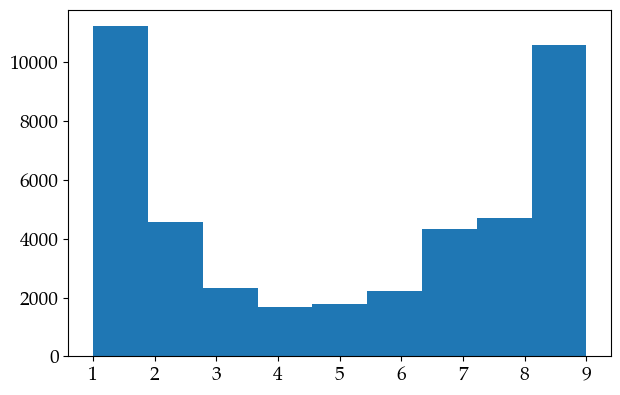

In [242]:
ncounts = np.concatenate([np.unique(np.array(evts_above_1000_dict[date]), return_counts=True)[1] for date in evts_above_1000_dict.keys()])
fig = plt.figure(figsize=(7, 4.5))
plt.hist(ncounts, bins=9)
plt.show()

In [184]:
filename = '/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-11_25_2024-file.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

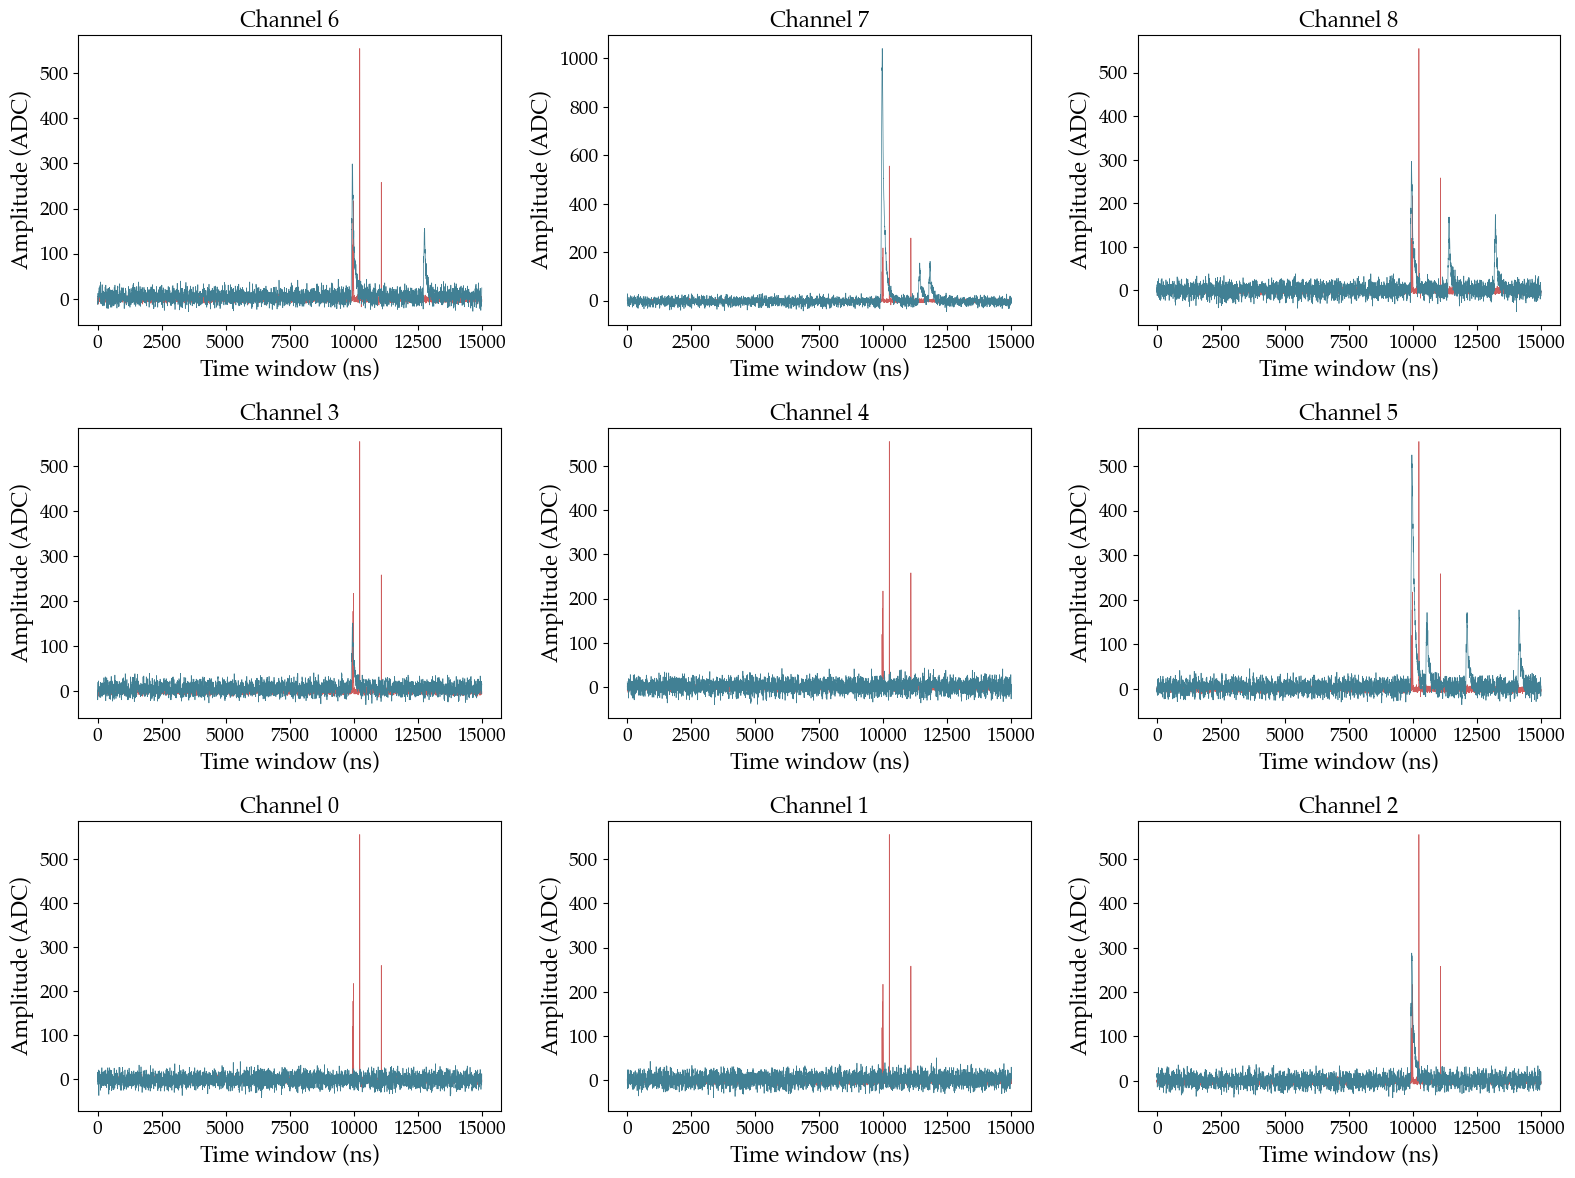

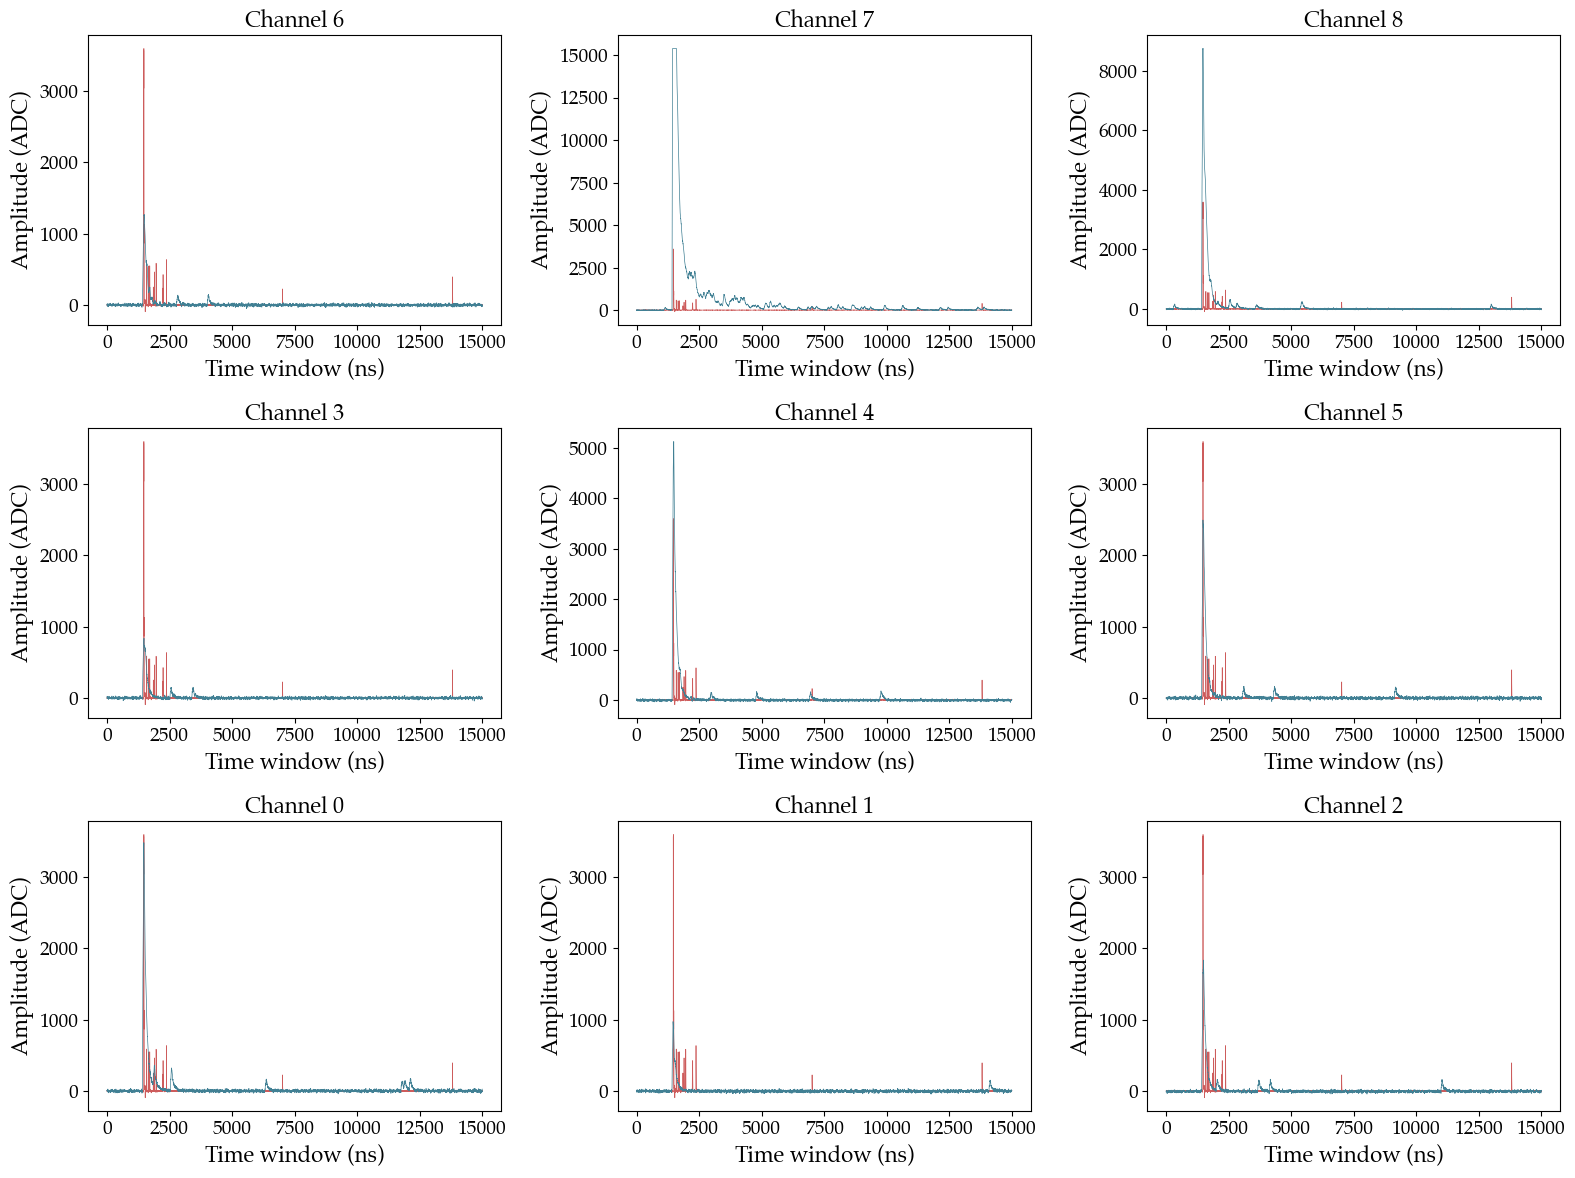

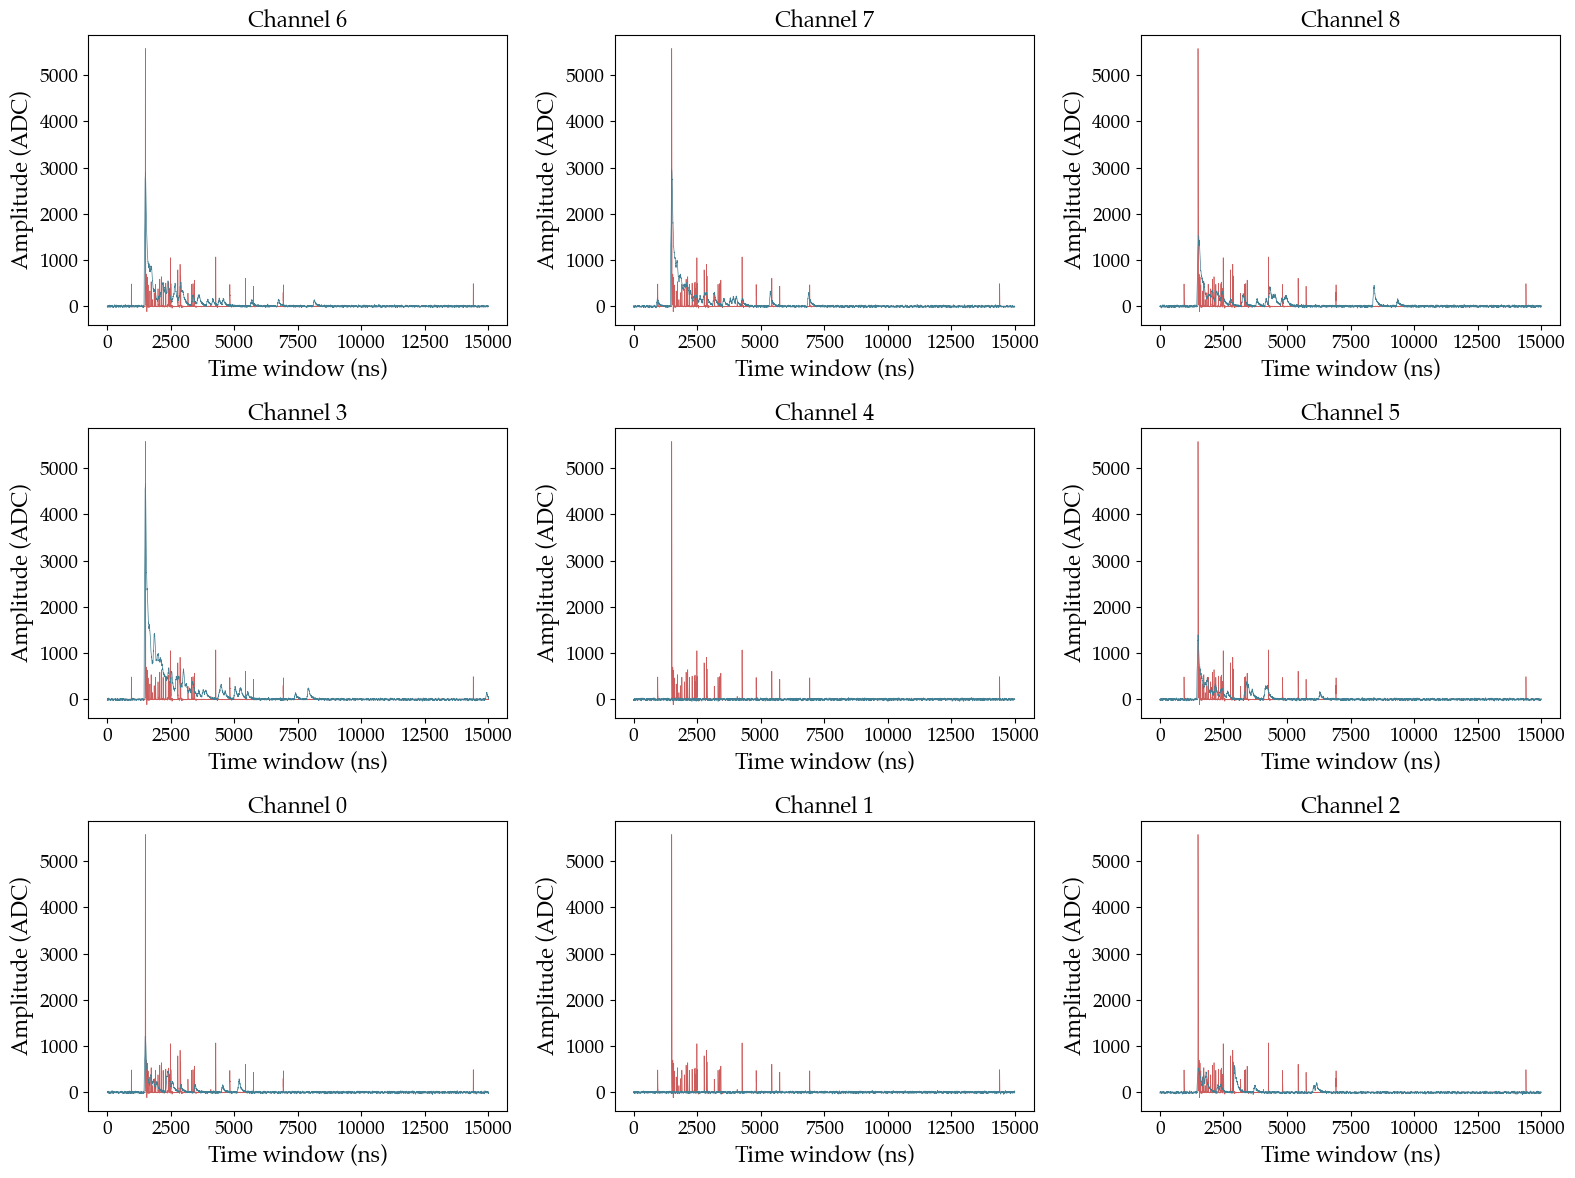

In [251]:
evt_list = [48, 119, 279, 614, 2144, 2639, 2825, 2963, 3029]
for evt in evt_list[4:7]:
    fig, axs   = plt.subplots(3, 3, figsize=(16, 12))
    wf0  = pf.wfs_from_rawtree(RawTree, 12)[evt]
    swf0 = blr.pmt_deconvolver(wf0, wf_range_bsl=(0, 650), baseline_mode=True, std_lim=3.6)
    for row, ich in enumerate(reversed(np.arange(0, 9, 3))):
        for col in range(3):
            ch   = ich + col
            wf1  = pf.wfs_from_rawtree(RawTree, ch)[evt]
            swf1 = pf.subtract_baseline(wf1, mode=True, wf_range_bsl=(0, 650))
            axs[row][col].plot(2*np.arange(len(swf0)), swf0, lw=0.5, color='indianred')
            axs[row][col].plot(2*np.arange(len(swf1)), swf1, lw=0.5, color=fav_col)
            axs[row][col].set_xlabel('Time window (ns)', fontsize=16)
            axs[row][col].set_ylabel('Amplitude (ADC)',  fontsize=16)
            axs[row][col].set_title(f"Channel {ch}",     fontsize=16)
    plt.tight_layout()
    plt.show()

### Try computing time dist after calibrating amplitudes

In [37]:
### Gains to calibrate the channels
## With the trigger channels it depends on the date because there were more variations

gains_all_chs = {0: (142.951, 5.925),
                 1: (132.500, -3.333),
                 2: (135.502, 12.886),
                 3: (135.000, -5.000),
                 4: (143.315,  5.262),
                 5: (137.660, 11.814),
                 6: (130.000, 0.),
                 7: (138.123, 12.840),
                 8: (131.772, 13.920),
                 9: {'09_10_2024': (713.445, -20.038), 
                     '09_11_2024': (716.176, -19.673), 
                     '09_12_2024': (719.783, -10.151), 
                     '09_20_2024': (722.221, -11.124), 
                     '09_25_2024': (723.042, -11.830), 
                     '09_28_2024': (721.611, -12.276), 
                     '10_04_2024': (720.181, -12.722), 
                     '10_11_2024': (725.152, -12.032), 
                     '10_17_2024': (728.640, -11.851), 
                     '10_25_2024': (722.907, -12.550), 
                     '11_01_2024': (724.566, -11.215), 
                     '11_11_2024': (714.408, -12.857), 
                     '11_25_2024': (704.251, -14.499), 
                     '12_13_2024': (691.857,   2.794), 
                     '12_21_2024': (680.420,  -3.534), 
                     '01_02_2025': (671.088,   4.511), 
                     '01_10_2025': (703.052,   0.083), 
                     '01_19_2025': (707.833,  -5.059)},
                 
                 10: {'09_10_2024': (707.800, 43.580), 
                      '09_11_2024': (707.968, 44.407), 
                      '09_12_2024': (706.610, 45.092), 
                      '09_20_2024': (703.655, 53.165), 
                      '09_25_2024': (703.754, 53.722), 
                      '09_28_2024': (704.139, 52.949), 
                      '10_04_2024': (705.643, 52.823), 
                      '10_11_2024': (706.706, 53.208), 
                      '10_17_2024': (707.740, 53.039), 
                      '10_25_2024': (707.276, 53.987), 
                      '11_01_2024': (705.825, 54.078), 
                      '11_11_2024': (705.377, 53.354), 
                      '11_25_2024': (705.761, 52.763), 
                      '12_13_2024': (709.026, 53.851), 
                      '12_21_2024': (709.094, 55.053), 
                      '01_02_2025': (709.721, 55.118), 
                      '01_10_2025': (710.348, 55.183), 
                      '01_19_2025': (711.481, 54.422)},
                 
                 11: {'09_10_2024': (641.030, 48.974), 
                      '09_11_2024': (642.714, 47.617), 
                      '09_12_2024': (645.527, 48.325), 
                      '09_20_2024': (648.580, 45.411), 
                      '09_25_2024': (651.633, 42.497), 
                      '09_28_2024': (651.651, 42.437), 
                      '10_04_2024': (652.104, 42.815), 
                      '10_11_2024': (652.307, 42.757), 
                      '10_17_2024': (652.510, 42.698), 
                      '10_25_2024': (641.258, 60.174), 
                      '11_01_2024': (647.961, 51.403), 
                      '11_11_2024': (654.665, 42.632), 
                      '11_25_2024': (656.109, 43.477), 
                      '12_13_2024': (656.052, 44.115), 
                      '12_21_2024': (655.995, 44.754), 
                      '01_02_2025': (655.938, 45.393), 
                      '01_10_2025': (655.881, 46.032), 
                      '01_19_2025': (656.365, 44.774)}}

In [38]:
start_time = time.time()

filt_evts_dict_cal = {}
idx_max_cal        = {}
height_sg_cal      = {}

normal_chs  = range(9)
trigger_chs = [9, 10, 11]

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)

    if date not in filt_evts_dict_cal:
        print(date)
        filt_evts_dict_cal[date] = {ch: d['filt_evts_dict']                .item()[ch]  for ch in normal_chs}
        idx_max_cal       [date] = {ch: np.concatenate(d['idx_peaks_max']  .item()[ch]) for ch in normal_chs}
        height_sg_cal     [date] = {ch: np.concatenate((d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0]) for ch in normal_chs}
    else:
        for ch in normal_chs:
            try:
                filt_evts_dict_cal[date][ch] = np.concatenate((filt_evts_dict_cal[date][ch], adapt_evt_id(d['filt_evts_dict'].item()[ch], fnum)))
                idx_max_cal       [date][ch] = np.concatenate((idx_max_cal       [date][ch], np.concatenate(d['idx_peaks_max']  .item()[ch])))
                height_sg_cal     [date][ch] = np.concatenate((height_sg_cal     [date][ch], np.concatenate((d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0])))
            except Exception as e:
                print(date, fnum, filename, ch, str(e))
                continue
                
end_time     = time.time()                
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1379
0
09_10_2024
09_11_2024
20
40
09_12_2024
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
10_04_2024
300
320
340
360
10_04_2024 79 /Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/BACoN_run3_hits_and_times_thr80_mean_w30_dist50_abs_vals_run-10_04_2024-file_79.npz 4 need at least one array to concatenate
10_11_2024
380
400
420
440
460
10_17_2024
480
500
520
540
560
10_25_2024
580
600
620
640
11_01_2024
660
680
700
720
11_11_2024
740
760
780
800
820
11_25_2024
840
860
880
900
920
12_13_2024
940
960
980
1000
1020
12_21_2024
1040
1060
1080
1100
01_02_2025
1120
1140
1160
1180
1200
01_10_2025
1220
1240
1260
1280
01_19_2025
1300
1320
1340
1360
Elapsed time: 270.76493525505066 s, 4.512748920917511 min


In [39]:
sel_dates = idx_max_cal.keys()
uniq_ts_cal   = {}
sum_ampls_cal = {}
for ch in normal_chs:
    print(ch)
    uniq_ts_ch, sum_ampls_ch = get_t_dist_from_hit_map(2*np.concatenate([idx_max_cal  [date][ch] for date in sel_dates]),
                                                         np.concatenate([height_sg_cal[date][ch] for date in sel_dates]))
    uniq_ts_cal  [ch] = uniq_ts_ch
    sum_ampls_cal[ch] = sum_ampls_ch

0
1
2
3
4
5
6
7
8


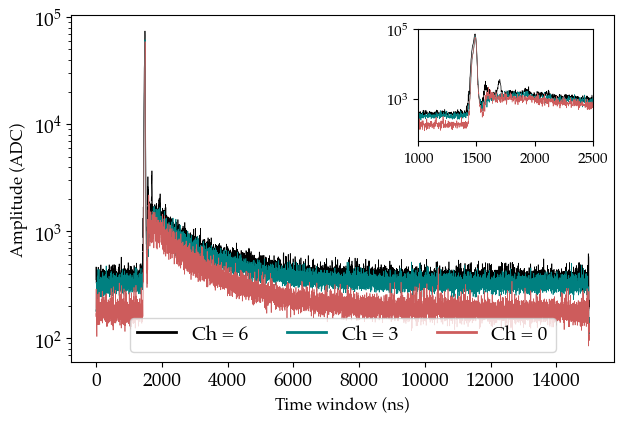

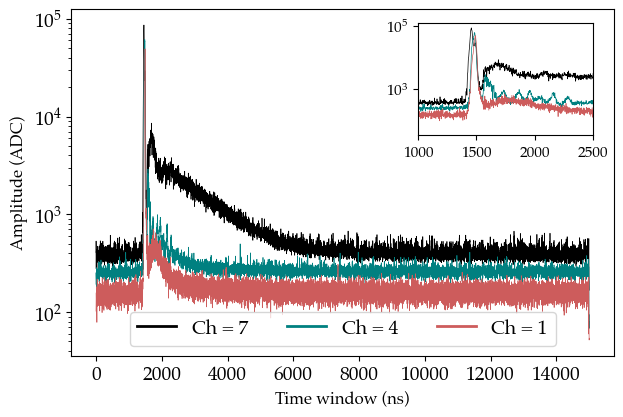

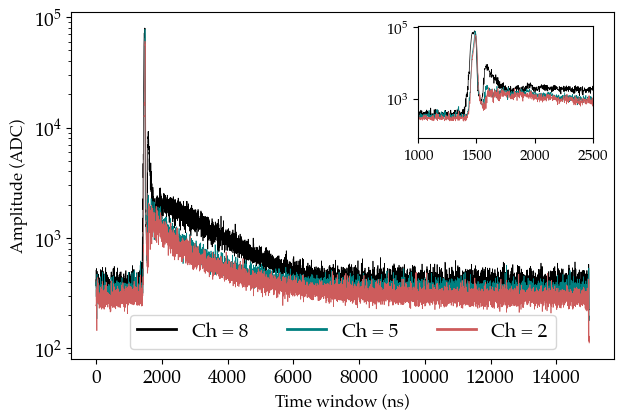

In [40]:
sel_dates = idx_max_cal.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_cal[ch], sum_ampls_cal[ch]
        plt.plot(unique_tstamps, sum_ampl, lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    #plt.ylim(8e3, 1e6)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        unique_tstamps, sum_ampl = uniq_ts_cal[ch], sum_ampls_cal[ch]
        ax_inset.plot(unique_tstamps, sum_ampl, c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    #ax_inset.set_ylim(8e3, 1e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

## Get only high light events but calibrating

In [41]:
start_time = time.time()
idx_max_hl2_cal   = {}
height_sg_hl2_cal = {}
num_evts_hl2_cal  = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    for ch in normal_chs:
        idx_after_cut    = []
        height_after_cut = []
        num_evts         = 0
        idx_peaks_ch     = d['idx_peaks_max']  .item()[ch]
        height_peaks_ch  = d['height_peaks_sg'].item()[ch]
        
        for idxs, vals in zip(idx_peaks_ch, height_peaks_ch):
            if len(idxs)==0:
                continue
            #noise_evts = (np.array(idxs)<650)&(np.array(vals)>100)
            #if np.any(noise_evts):
            #    continue
            if np.any(np.array(vals) > 1000):
                idx_after_cut   .append(idxs)
                height_after_cut.append((vals-gains_all_chs[ch][1])/gains_all_chs[ch][0])
                num_evts += 1
            else:
                continue
                
        if date not in idx_max_hl2_cal:
            print(date)
            idx_max_hl2_cal  [date] = {}
            height_sg_hl2_cal[date] = {}
            num_evts_hl2_cal [date] = {}

        if ch not in idx_max_hl2_cal[date]:
            try:
                idx_max_hl2_cal  [date][ch] = np.concatenate(idx_after_cut)
                height_sg_hl2_cal[date][ch] = np.concatenate(height_after_cut)
                num_evts_hl2_cal [date][ch] = np.array([num_evts])
            except Exception as e:
                print(e)
                continue
        else:
            try:
                idx_max_hl2_cal  [date][ch] = np.concatenate((idx_max_hl2_cal  [date][ch], np.concatenate(idx_after_cut)))
                height_sg_hl2_cal[date][ch] = np.concatenate((height_sg_hl2_cal[date][ch], np.concatenate(height_after_cut)))
                num_evts_hl2_cal [date][ch] = np.concatenate((num_evts_hl2_cal [date][ch], np.array([num_evts])))
            except Exception as e:
                print(e)
                continue

end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1379
0
09_10_2024
need at least one array to concatenate
09_11_2024
20
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
40
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
09_12_2024
need at least one array to concatenate
need at least one array to concatenate
60
09_20_2024
80
100
120
140
160
09_25_2024
180
200
220
09_28_2024
240
260
280
10_04_2024
300
320
340
360
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
10_11_2024
380
400
420
440
460
10_17_2024
480
500
520
540
560
10_25_2024
need at least one array to concate

In [42]:
sel_dates = idx_max_hl2_cal.keys()
uniq_ts_hl2_cal   = {}
sum_ampls_hl2_cal = {}
for ch in normal_chs:
    print(ch)
    uniq_ts_ch, sum_ampls_ch = get_t_dist_from_hit_map(2*np.concatenate([idx_max_hl2_cal  [date][ch] for date in sel_dates]),
                                                         np.concatenate([height_sg_hl2_cal[date][ch] for date in sel_dates]))
    uniq_ts_hl2_cal  [ch] = uniq_ts_ch
    sum_ampls_hl2_cal[ch] = sum_ampls_ch

0
1
2
3
4
5
6
7
8


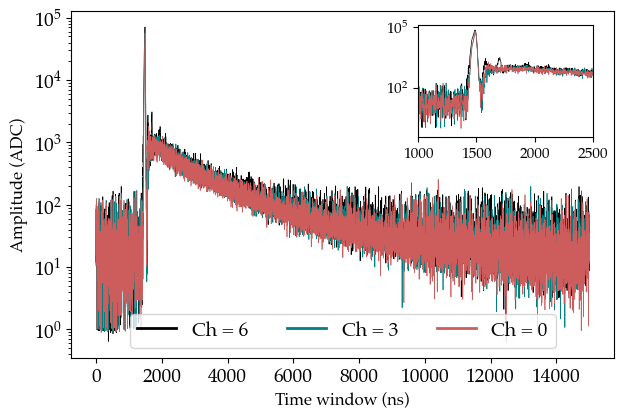

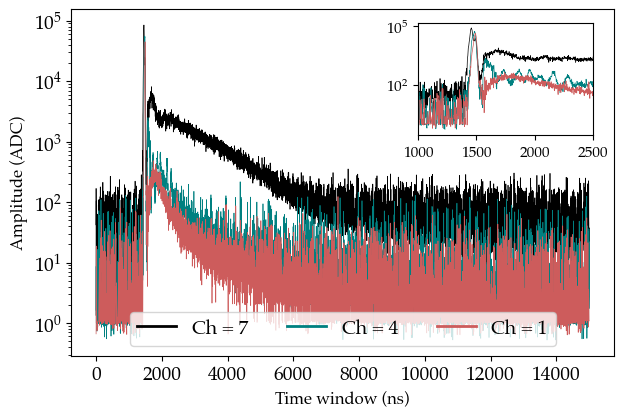

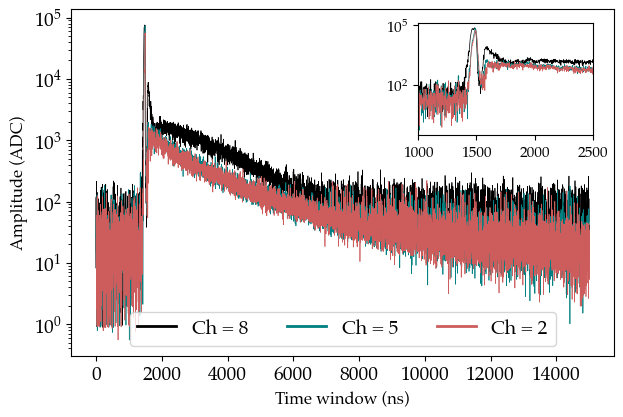

In [43]:
sel_dates = idx_max_hl2_cal.keys()

for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        plt.plot(uniq_ts_hl2_cal[ch], sum_ampls_hl2_cal[ch], lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    #plt.ylim(8e3, 1e6)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        ax_inset.plot(uniq_ts_hl2_cal[ch], sum_ampls_hl2_cal[ch], c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    #ax_inset.set_ylim(8e3, 1e6)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

## Combine all results:

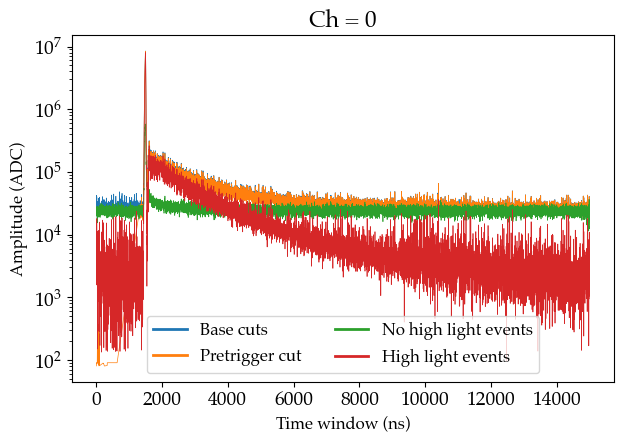

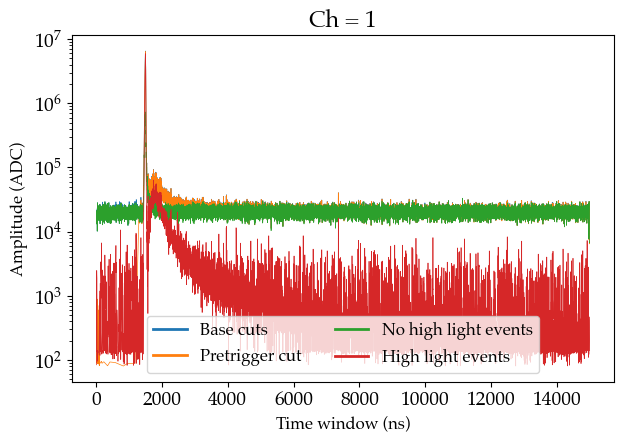

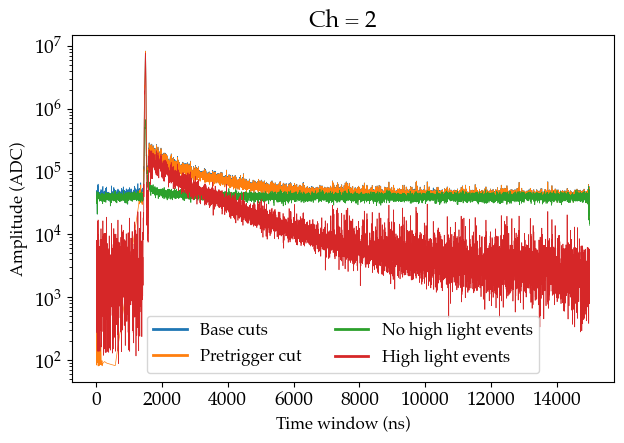

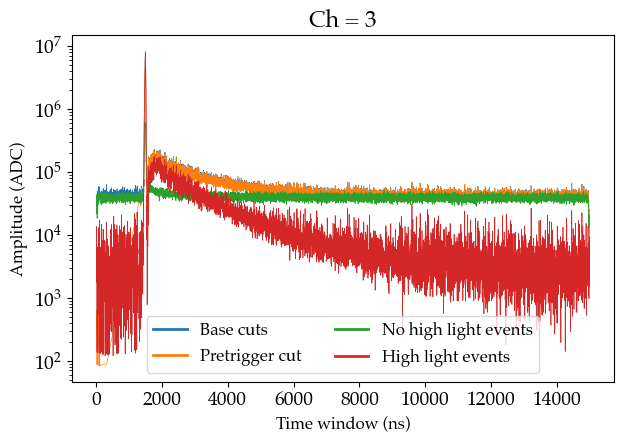

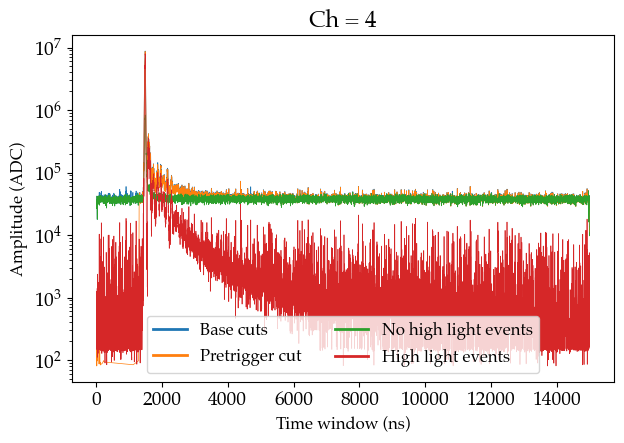

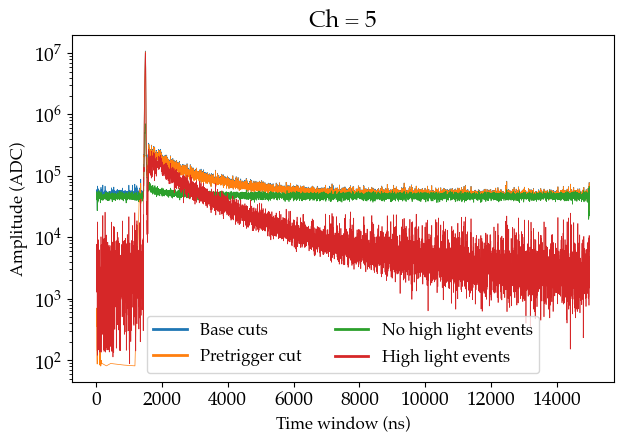

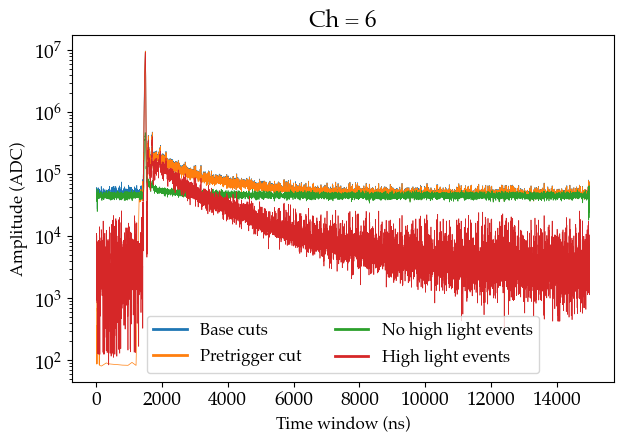

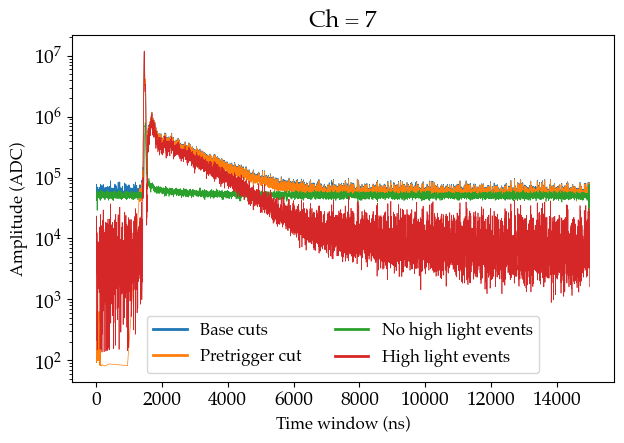

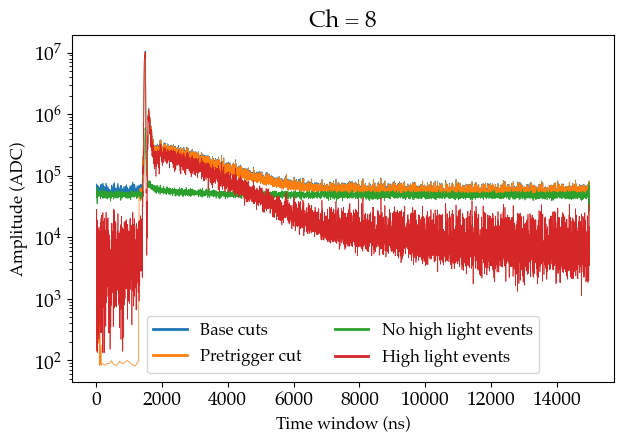

In [53]:
for ch in normal_chs:
    fig = plt.figure(figsize=(7, 4.5))
    plt.plot(uniq_ts        [ch], sum_ampls        [ch], lw=0.5, label=f'Base cuts')
    plt.plot(uniq_ts_pt     [ch], sum_ampls_pt     [ch], lw=0.5, label=f'Pretrigger cut')
    plt.plot(uniq_ts_hl     [ch], sum_ampls_hl     [ch], lw=0.5, label=f'No high light events')
    plt.plot(uniq_ts_hl2    [ch], sum_ampls_hl2    [ch], lw=0.5, label=f'High light events')
    plt.title(f'Ch = {ch}')
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    #plt.ylim(8e3, 1e6)
    leg = plt.legend(loc='lower center', fontsize=12, ncol=2)
    for line in leg.get_lines():
        line.set_linewidth(2)
    plt.show()

## Try to select single PE per whole event as in LLAMA

In [56]:
start_time = time.time()

filt_evts_dict_1pe = {}
idx_max_1pe        = {}
height_sg_1pe      = {}

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)

    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    
    all_evts       = np.concatenate(list(d['filt_evts_dict'].item().values()))
    uniq_evts, cts = np.unique(all_evts, return_counts=True)
    uniq_evts_arr  = uniq_evts[cts == 1] ## Multiplicity cut between SiPMs
    
    for ch in normal_chs:
        
        npeak_wf = np.array([len(el) for el in d['idx_peaks_thr'].item()[ch]])
        sel1     = np.isin(d['filt_evts_dict'].item()[ch], uniq_evts_arr)
        sel2     = npeak_wf==1
        if len(sel1&sel2)==0:
            continue
        sel_evts =                d['filt_evts_dict'] .item()[ch][sel1&sel2]
        indices1 = np.concatenate(d['idx_peaks_max']  .item()[ch][sel1&sel2]).astype(int)
        heights1 = np.concatenate(d['height_peaks_sg'].item()[ch][sel1&sel2])
        
        sel3     = heights1 < 200 #amplitude < 200 ADC to select only single PE
        sel_evts = sel_evts[sel3]
        indices1 = indices1[sel3]
        heights1 = heights1[sel3]
        
    
        if date not in filt_evts_dict_1pe:
            filt_evts_dict_1pe[date] = {}
            idx_max_1pe       [date] = {}
            height_sg_1pe     [date] = {}
            
        if ch not in filt_evts_dict_1pe[date]:
            try:
                filt_evts_dict_1pe[date][ch] = sel_evts
                idx_max_1pe       [date][ch] = indices1
                height_sg_1pe     [date][ch] = heights1
            except Exception as e:
                print(e)
                continue
                
        else:
            try:
                filt_evts_dict_1pe[date][ch] = np.concatenate((filt_evts_dict_1pe[date][ch], sel_evts))
                idx_max_1pe       [date][ch] = np.concatenate((idx_max_1pe       [date][ch], indices1))
                height_sg_1pe     [date][ch] = np.concatenate((height_sg_1pe     [date][ch], heights1))
            except Exception as e:
                print(e)
                continue
                
end_time     = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1379
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
Elapsed time: 1179.984943151474 s, 19.66641571919123 min


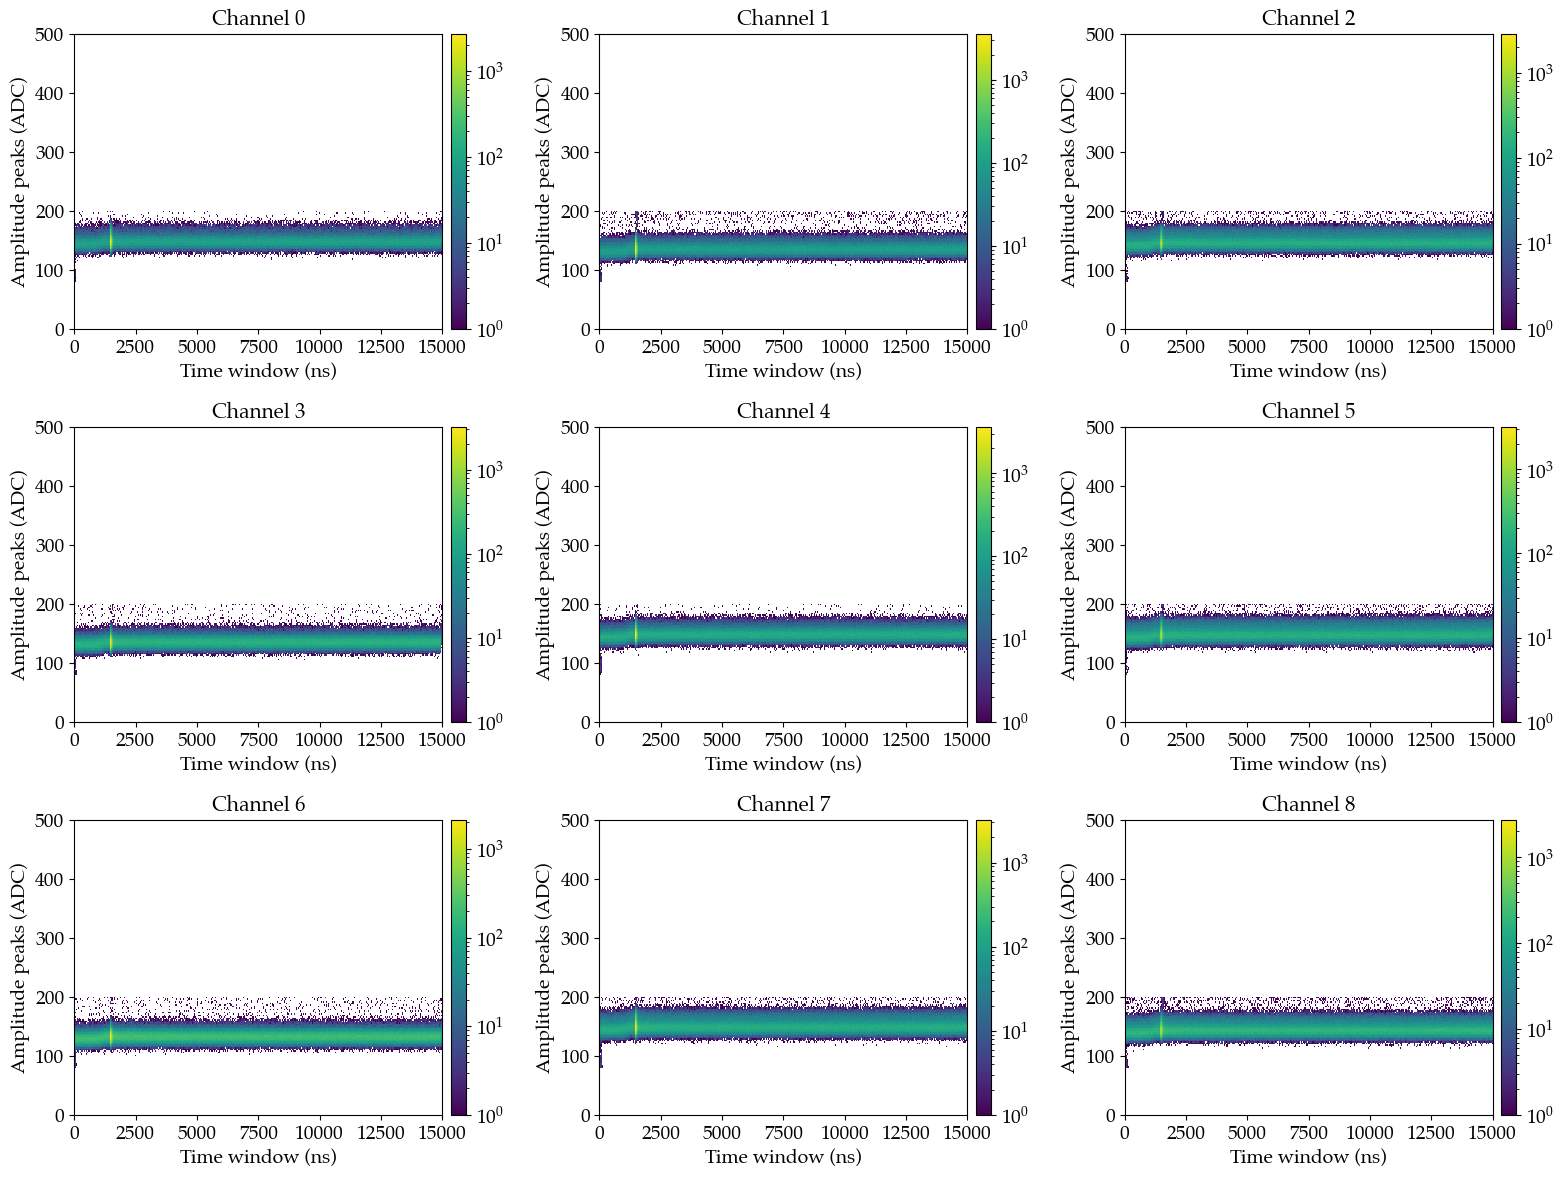

In [59]:
sel_dates = idx_max_1pe.keys()
fig, axs  = plt.subplots(3, 3, figsize=(16, 12))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
    
    try:
        ch_idxs = np.concatenate([idx_max_1pe  [date][ch] for date in sel_dates])
        ch_vals = np.concatenate([height_sg_1pe[date][ch] for date in sel_dates])
    
        fig0 = axs[i][j].hist2d(ch_idxs*2, ch_vals, bins=(500, 200), range=((0, 15000), (0, 500)), cmin=1, norm=LogNorm())
        axs[i][j].set_xlabel('Time window (ns)',      fontsize=14)
        axs[i][j].set_ylabel('Amplitude peaks (ADC)', fontsize=14)
        axs[i][j].set_title(f"Channel {ch}",          fontsize=15)
        fig.colorbar(fig0[3], ax=axs[i][j], pad=0.02)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
#plt.savefig(f'/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/hit_maps_1PE_alla_LLAMA.pdf', bbox_inches='tight')
plt.show()

In [61]:
sel_dates = idx_max_1pe.keys()
uniq_ts_1pe   = {}
sum_ampls_1pe = {}
for ch in normal_chs:
    print(ch)
    uniq_ts_ch, sum_ampls_ch = get_t_dist_from_hit_map(2*np.concatenate([idx_max_1pe  [date][ch] for date in sel_dates]),
                                                         np.concatenate([height_sg_1pe[date][ch] for date in sel_dates]))
    uniq_ts_1pe  [ch] = uniq_ts_ch
    sum_ampls_1pe[ch] = sum_ampls_ch

0
1
2
3
4
5
6
7
8


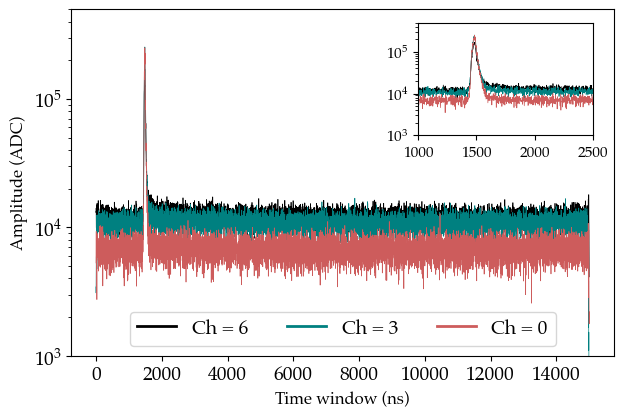

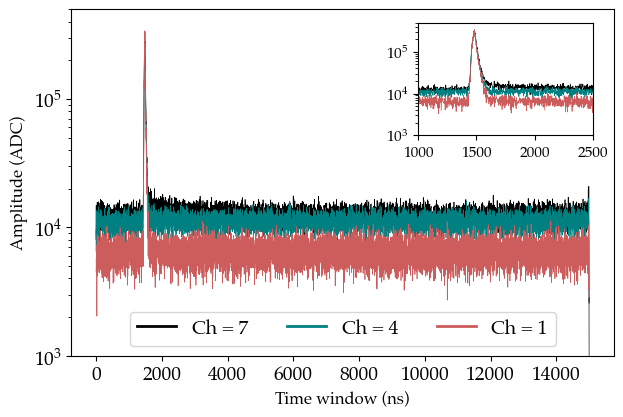

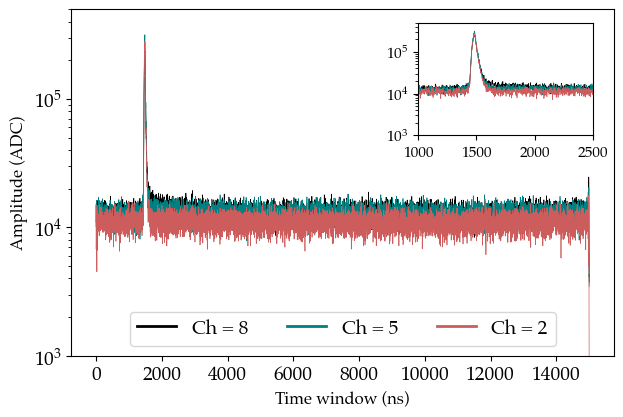

In [64]:
sel_dates = idx_max_1pe.keys()
for sel_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    fig = plt.figure(figsize=(7, 4.5))
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        plt.plot(uniq_ts_1pe[ch], sum_ampls_1pe[ch], lw=0.5, c=col, label=f'Ch = {ch}')
    
    plt.xlabel('Time window (ns)', fontsize=12)
    plt.ylabel('Amplitude (ADC)',  fontsize=12)
    plt.yscale('log')
    plt.ylim(1e3, 5e5)
    leg = plt.legend(loc='lower center', ncol=3)
    for line in leg.get_lines():
        line.set_linewidth(2)

    # Inset plot
    ax_inset = fig.add_axes([0.62, 0.60, 0.25, 0.25])
    for ch, col in zip(sel_chs, ['k', 'teal', 'indianred']):
        ax_inset.plot(uniq_ts_1pe[ch], sum_ampls_1pe[ch], c=col, lw=0.5)

    ax_inset.set_xlim(1000, 2500)
    ax_inset.set_ylim(1e3, 5e5)
    ax_inset.tick_params(axis='x', labelsize=11)
    ax_inset.tick_params(axis='y', labelsize=11)
    ax_inset.set_yscale('log')
    plt.show()

## Compute the number of PE per evt per SiPM and the sum of PEs for all channels

In [363]:
def remake_evt_pes(ch, d):
    event_numbers  = d['filt_evts_dict']  .item()[ch]
    event_numbers  = event_numbers.astype(int)
    photoelectrons = np.array(list(map(lambda x: np.sum(np.round(x).astype(int)), (d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0])), dtype=object)
    result_array   = np.zeros(len(d['idx_peaks_max_trigg'].item()[9]))
    result_array[event_numbers] = photoelectrons
    return result_array

In [369]:
start_time = time.time()

filt_evts_dict_cal2        = {}
idx_max_cal2               = {}
height_sg_cal2             = {}
height_sg_cal2_r_sum       = {}
filt_evts_dict_trigg_cal2  = {}
idx_max_trigg_cal2         = {}
height_sg_trigg_cal2       = {}
height_sg_trigg_cal2_r_sum = {}

normal_chs  = range(9)
trigger_chs = [9, 10, 11]

print(len(sorted_files))
for ifile,filename in enumerate(sorted_files):
    if ifile%20==0:
        print(ifile)
    d          = np.load(filename, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)

    if date not in filt_evts_dict_cal2:
        print(date)
        filt_evts_dict_cal2 [date] = {ch: d['filt_evts_dict']  .item()[ch] for ch in normal_chs}
        idx_max_cal2        [date] = {ch: d['idx_peaks_max']   .item()[ch] for ch in normal_chs}
        height_sg_cal2      [date] = {ch: (d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0] for ch in normal_chs}
        height_sg_cal2_r_sum[date] = {ch: remake_evt_pes(ch, d) for ch in normal_chs}
        
    else:
        for ch in normal_chs:
            try:
                filt_evts_dict_cal2 [date][ch] = np.concatenate((filt_evts_dict_cal2 [date][ch], adapt_evt_id(d['filt_evts_dict'].item()[ch], fnum)))
                idx_max_cal2        [date][ch] = np.concatenate((idx_max_cal2        [date][ch], d['idx_peaks_max']  .item()[ch]))
                height_sg_cal2      [date][ch] = np.concatenate((height_sg_cal2      [date][ch], (d['height_peaks_sg'].item()[ch]-gains_all_chs[ch][1])/gains_all_chs[ch][0]))
                height_sg_cal2_r_sum[date][ch] = np.concatenate((height_sg_cal2_r_sum[date][ch], remake_evt_pes(ch, d)))
            except Exception as e:
                print(date, fnum, filename, ch, str(e))
                continue
                
    if date not in idx_max_trigg_cal2:
        print(date)
        filt_evts_dict_trigg_cal2 [date] = {ch: adapt_evt_id(np.arange(len(d['idx_peaks_max_trigg'].item()[ch])), fnum) for ch in trigger_chs}
        idx_max_trigg_cal2        [date] = {ch: d['idx_peaks_max_trigg']   .item()[ch] for ch in trigger_chs}
        height_sg_trigg_cal2      [date] = {ch: (d['height_peaks_sg_trigg'].item()[ch]-gains_all_chs[ch][date][1])/gains_all_chs[ch][date][0] for ch in trigger_chs}
        height_sg_trigg_cal2_r_sum[date] = {ch: np.array(list(map(lambda x: np.sum(np.round(x).astype(int)), (d['height_peaks_sg_trigg'].item()[ch]-gains_all_chs[ch][date][1])/gains_all_chs[ch][date][0])), dtype=object) for ch in trigger_chs}
    else:
        for ch in trigger_chs:
            try:
                filt_evts_dict_trigg_cal2 [date][ch] = np.concatenate((filt_evts_dict_trigg_cal2 [date][ch], adapt_evt_id(np.arange(len(d['idx_peaks_max_trigg'].item()[ch])), fnum)))
                idx_max_trigg_cal2        [date][ch] = np.concatenate((idx_max_trigg_cal2        [date][ch], d['idx_peaks_max_trigg']  .item()[ch]))
                height_sg_trigg_cal2      [date][ch] = np.concatenate((height_sg_trigg_cal2      [date][ch], (d['height_peaks_sg_trigg'].item()[ch]-gains_all_chs[ch][date][1])/gains_all_chs[ch][date][0]))
                height_sg_trigg_cal2_r_sum[date][ch] = np.concatenate((height_sg_trigg_cal2_r_sum[date][ch], np.array(list(map(lambda x: np.sum(np.round(x).astype(int)), (d['height_peaks_sg_trigg'].item()[ch]-gains_all_chs[ch][date][1])/gains_all_chs[ch][date][0])), dtype=object)))
            except Exception as e:
                print(date, fnum, filename, ch, str(e))
                continue
                
end_time     = time.time()                
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} s, {elapsed_time/60} min")

1379
0
09_10_2024
09_10_2024
09_11_2024
09_11_2024
20
40
09_12_2024
09_12_2024
60
09_20_2024
09_20_2024
80
100
120
140
160
09_25_2024
09_25_2024
180
200
220
09_28_2024
09_28_2024
240
260
280
10_04_2024
10_04_2024
300
320
340
360
10_04_2024 79 /Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/BACoN_run3_hits_and_times_thr80_mean_w30_dist50_abs_vals_run-10_04_2024-file_79.npz 1 all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
10_04_2024 79 /Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/BACoN_run3_hits_and_times_thr80_mean_w30_dist50_abs_vals_run-10_04_2024-file_79.npz 3 all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
10_04_2024 79 /Users/romoluque_c/LEGEND/BACON/new_setup/data_npz_run3/BACoN_run3_hits_and_times_thr80_mean_w30_dist50_abs_vals_run-10_04_2024-file_79.npz 4 'list' obje

In [395]:
sum_pes_normal_chs = []
for ch in normal_chs:
    sum_pes_normal_chs.append(np.concatenate(([height_sg_cal2_r_sum[date][ch] for date in height_sg_cal2_r_sum.keys() if date!='10_04_2024'])))
sum_pes_normal_chs = np.sum(sum_pes_normal_chs, axis=0)

sum_pes_trigg_chs = []
for ch in trigger_chs:
    sum_pes_trigg_chs.append(np.concatenate(([height_sg_trigg_cal2_r_sum[date][ch] for date in height_sg_trigg_cal2_r_sum.keys() if date!='10_04_2024'])))
sum_pes_trigg_chs = np.sum(sum_pes_trigg_chs, axis=0)

sum_pes_all_chs = sum_pes_normal_chs + sum_pes_trigg_chs

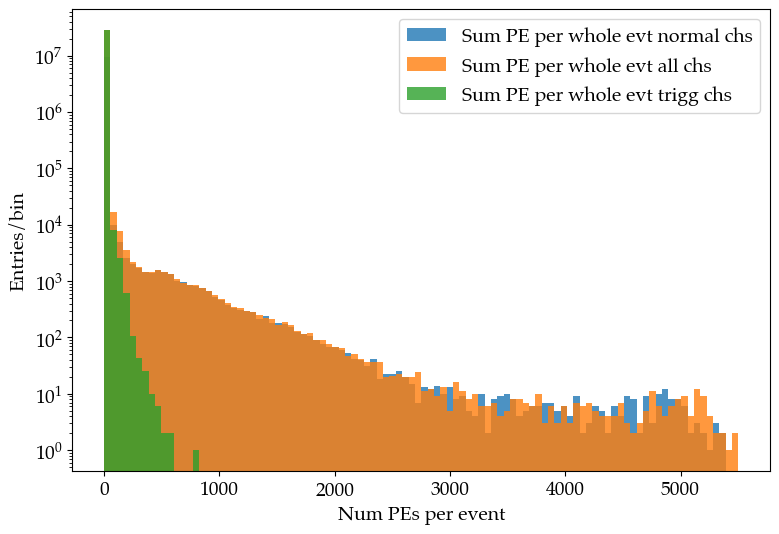

In [410]:
plt.hist(sum_pes_normal_chs[sum_pes_normal_chs>0], bins=100, log=True, range=(0, 5500), alpha=0.8, label='Sum PE per whole evt normal chs')
plt.hist(sum_pes_all_chs   [sum_pes_all_chs   >0], bins=100, log=True, range=(0, 5500), alpha=0.8, label='Sum PE per whole evt all chs')
plt.hist(sum_pes_trigg_chs [sum_pes_trigg_chs >0], bins=100, log=True, range=(0, 5500), alpha=0.8, label='Sum PE per whole evt trigg chs')
plt.xlabel('Num PEs per event')
plt.ylabel('Entries/bin')
plt.legend()
plt.show()

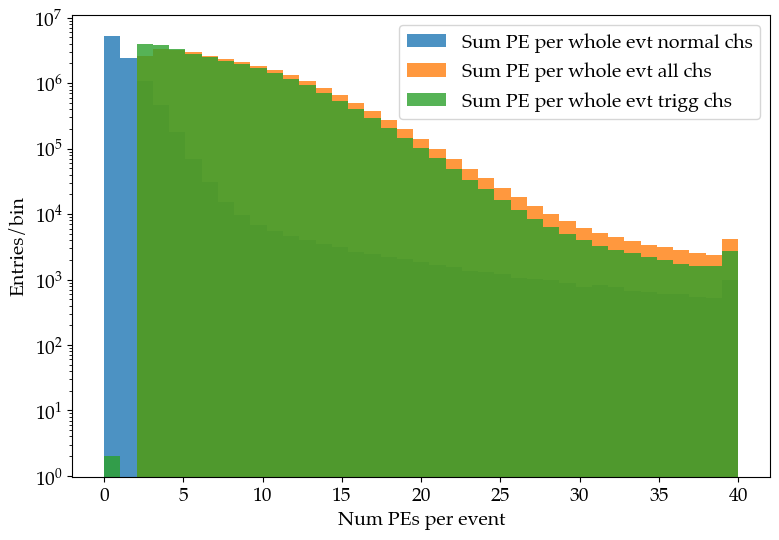

In [411]:
plt.hist(sum_pes_normal_chs[sum_pes_normal_chs>0], bins=39, log=True, range=(0, 40), alpha=0.8, label='Sum PE per whole evt normal chs')
plt.hist(sum_pes_all_chs   [sum_pes_all_chs   >0], bins=39, log=True, range=(0, 40), alpha=0.8, label='Sum PE per whole evt all chs')
plt.hist(sum_pes_trigg_chs [sum_pes_trigg_chs >0], bins=39, log=True, range=(0, 40), alpha=0.8, label='Sum PE per whole evt trigg chs')
plt.xlabel('Num PEs per event')
plt.ylabel('Entries/bin')
plt.legend()
plt.show()

## Compute the number of PEs for each individual channel

In [91]:
height_sg_cal2_int = {}
for date in height_sg_cal2.keys():
    print(date)
    height_sg_cal2_int[date] = {}
    for ch in normal_chs:
        height_sg_cal2_int[date][ch] = np.array([np.round(el).astype(int) for el in height_sg_cal2[date][ch]], dtype='object')

09_10_2024
09_11_2024
09_12_2024
09_20_2024
09_25_2024
09_28_2024
10_04_2024
10_11_2024
10_17_2024
10_25_2024
11_01_2024
11_11_2024
11_25_2024
12_13_2024
12_21_2024
01_02_2025
01_10_2025
01_19_2025


In [114]:
height_sg_cal2_int_sum = {}
for date in height_sg_cal2.keys():
    print(date)
    height_sg_cal2_int_sum[date] = {}
    for ch in normal_chs:
        height_sg_cal2_int_sum[date][ch] = np.array([np.sum(el) for el in height_sg_cal2_int[date][ch]])

09_10_2024
09_11_2024
09_12_2024
09_20_2024
09_25_2024
09_28_2024
10_04_2024
10_11_2024
10_17_2024
10_25_2024
11_01_2024
11_11_2024
11_25_2024
12_13_2024
12_21_2024
01_02_2025
01_10_2025
01_19_2025


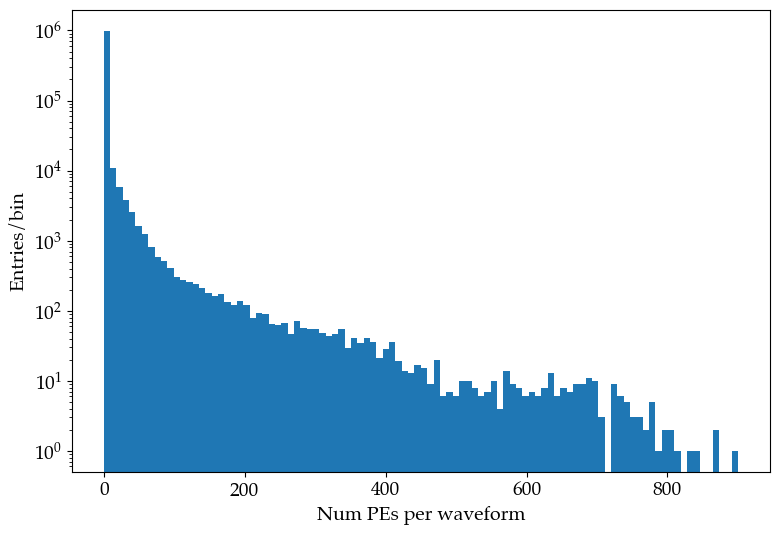

In [117]:
num_pes_ch = np.concatenate([height_sg_cal2_int_sum[date][0] for date in height_sg_cal2_int_sum.keys()])
plt.hist(num_pes_ch, bins=100, log=True)
plt.xlabel('Num PEs per waveform')
plt.ylabel('Entries/bin');

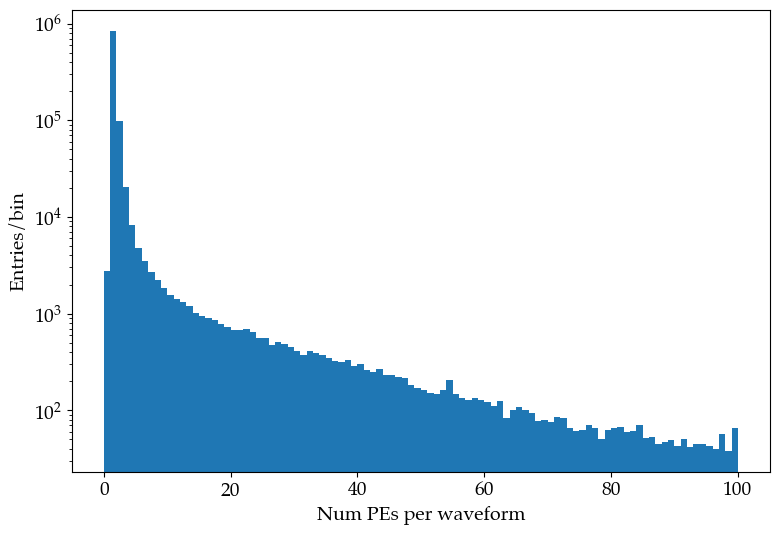

In [115]:
num_pes_ch = np.concatenate([height_sg_cal2_int_sum[date][0] for date in height_sg_cal2_int_sum.keys()])
plt.hist(num_pes_ch, bins=100, range=(0, 100), log=True)
plt.xlabel('Num PEs per waveform')
plt.ylabel('Entries/bin');

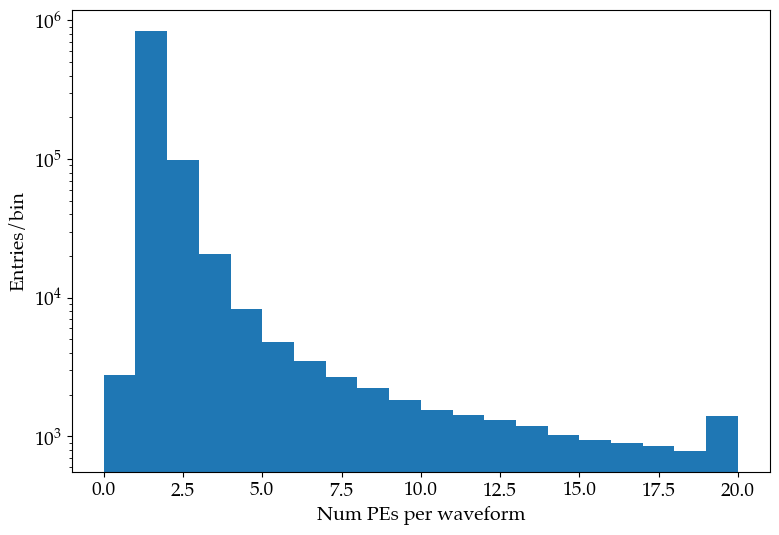

In [123]:
num_pes_ch = np.concatenate([height_sg_cal2_int_sum[date][0] for date in height_sg_cal2_int_sum.keys()])
plt.hist(num_pes_ch, bins=20, range=(0, 20), log=True)
plt.xlabel('Num PEs per waveform')
plt.ylabel('Entries/bin');

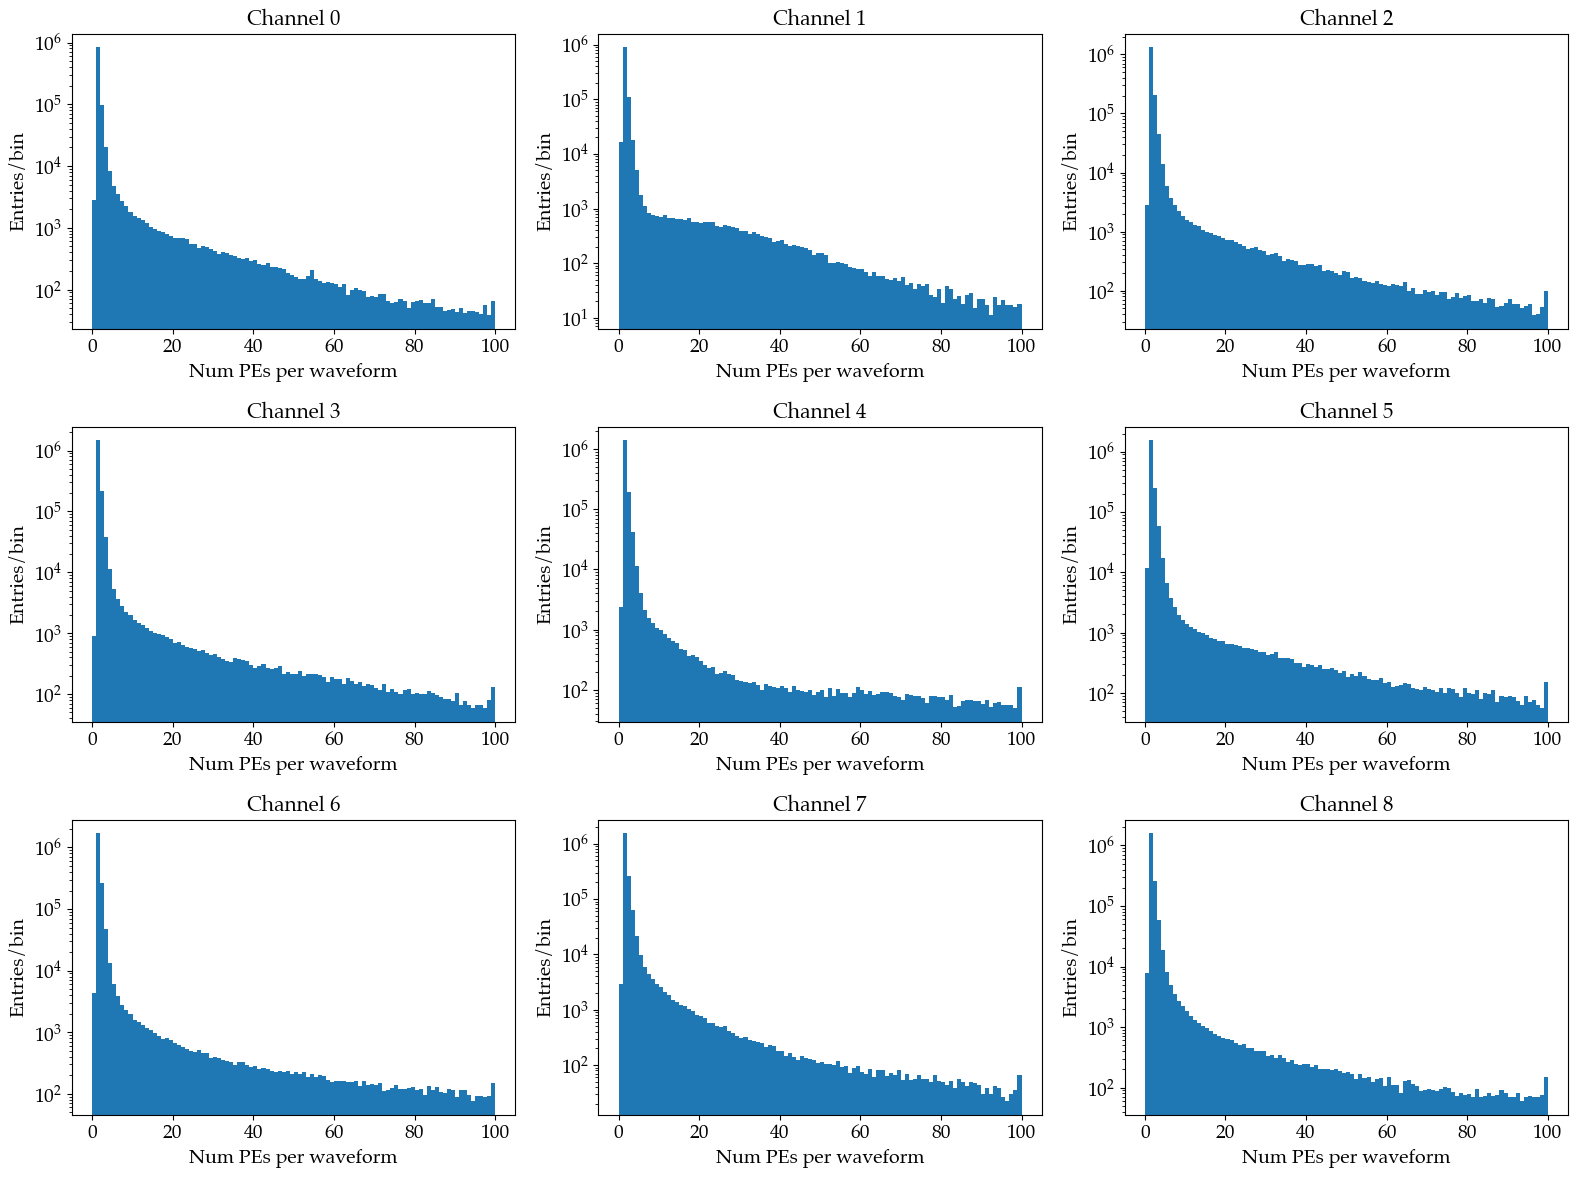

In [116]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
    
    try:
        num_pes_ch = np.concatenate([height_sg_cal2_int_sum[date][ch] for date in height_sg_cal2_int_sum.keys()])

        axs[i][j].hist(num_pes_ch, bins=100, range=(0, 100), log=True)
        axs[i][j].set_xlabel('Num PEs per waveform', fontsize=14)
        axs[i][j].set_ylabel('Entries/bin',          fontsize=14)
        axs[i][j].set_title(f"Channel {ch}",         fontsize=15)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
plt.show()

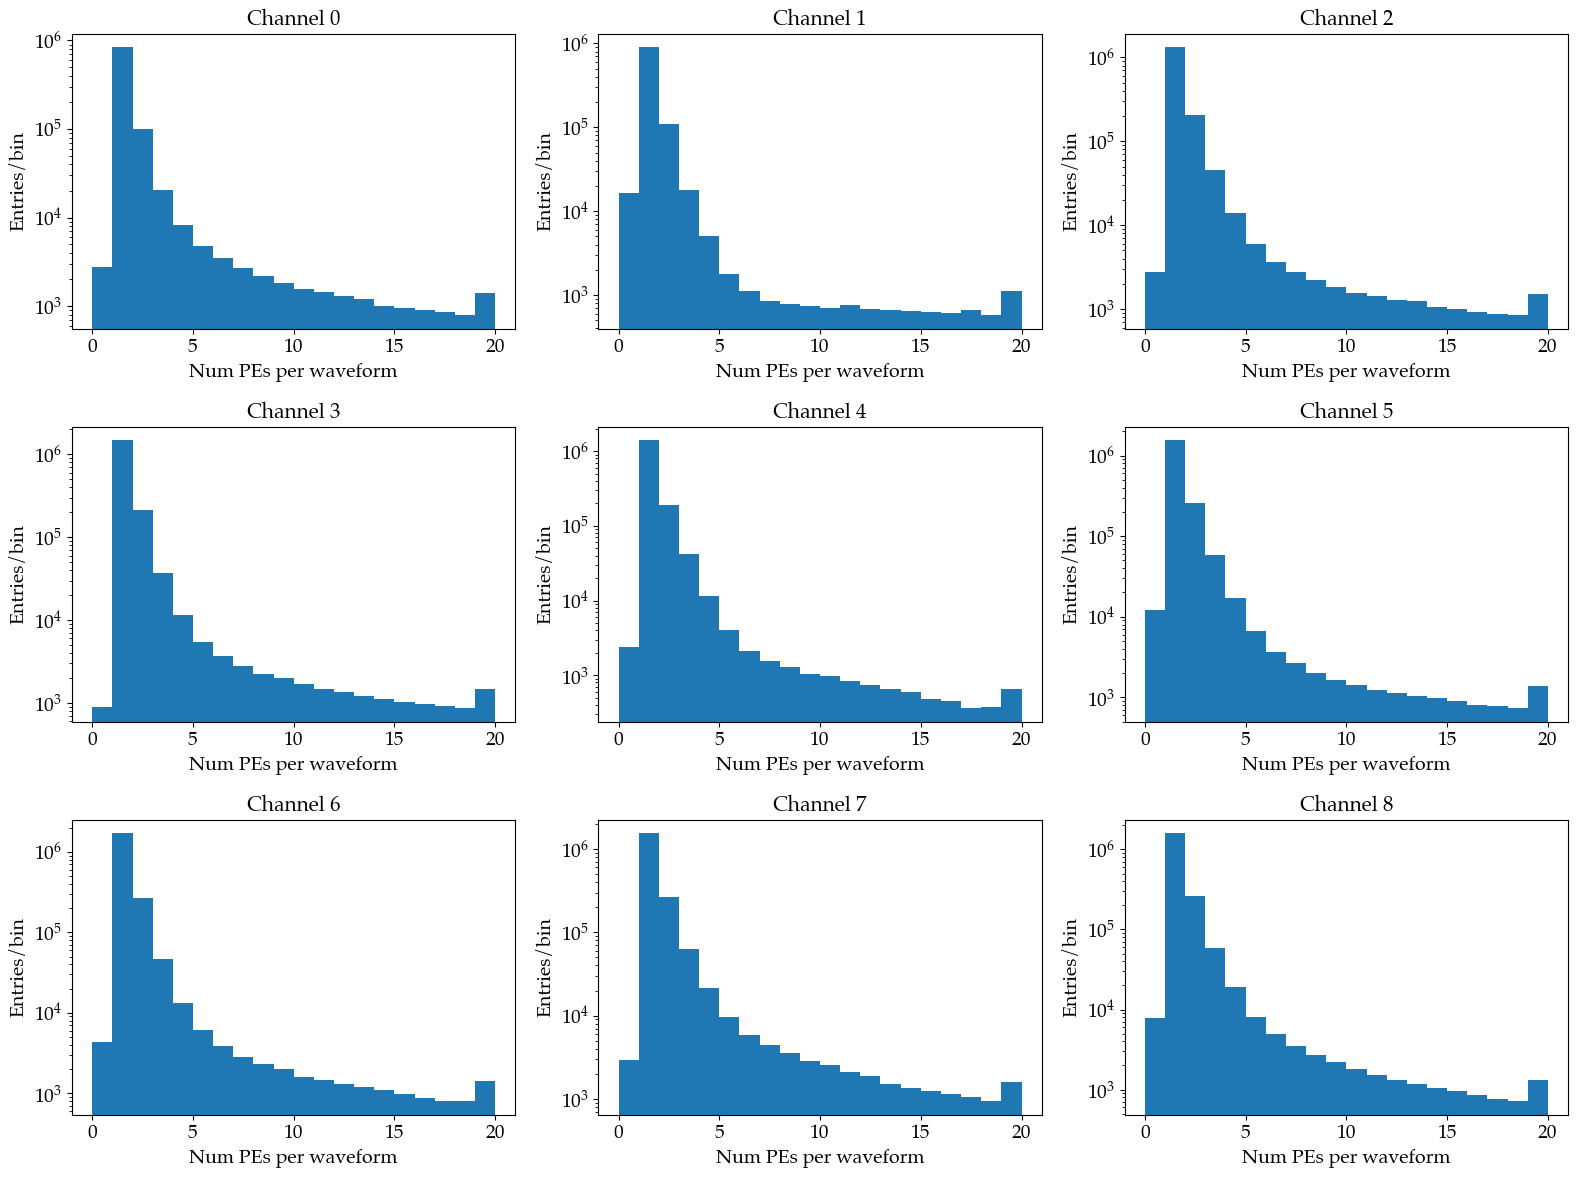

In [124]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for ch in normal_chs:
    i = int(ch/3)
    j = ch%3
    
    try:
        num_pes_ch = np.concatenate([height_sg_cal2_int_sum[date][ch] for date in height_sg_cal2_int_sum.keys()])

        axs[i][j].hist(num_pes_ch, bins=20, range=(0, 20), log=True)
        axs[i][j].set_xlabel('Num PEs per waveform', fontsize=14)
        axs[i][j].set_ylabel('Entries/bin',          fontsize=14)
        axs[i][j].set_title(f"Channel {ch}",         fontsize=15)
    except Exception as e:
        print(e)
        continue
plt.tight_layout()
plt.show()